Okay, time to rebuild our old statistical pipeline as best as we can. We will keep only the essential portions, in the interests of time and clarity.

## Contents

[Importing biom table and setup](#import)  


[Controls](#controls)
 - [Negative controls](#negC)
 - [Positive controls (mock community)](#mock)
   - [Genomic](#gPos)
   - [ITS-only](#iPos)
 - [Cleanup using controls](#cleanup)  
    - [Removing low abundance samples](#lowSamp)  
    - [Minimum abundances of observations and contaminant removal](#minAbund)
    - [Subtracting contaminant abundances](#subContam)
    - [Remove all mock community OTUs](#remMCs)  
    
[Variance stabilization of reads](#varstab)
  - [Apply DESeq2 algorithms](#DESeq2)
  - [Compare pre/post variance-stabilization distibutions](#BAvarstab)

[NMS/PERMANOVA Ordinations](#NMSs)
  - [Wood vs. Leaf libraries, all reads](#WvLNMS)
  - [Wood vs. Leaf endophyte comparison, look for shared species](#WvLshared)
  - [Host NMS/PermANOVA](#HostNMS)
  - [Wood library, Host effects](#woodHostNMS)
  - [Leaf library, Host effects](#leafHostNMS)

<a id='import'><h2>Importing biom table and setup</h2></a>

In [107]:
library('phyloseq')
library('DESeq2')
library('vegan')
library('cooccur')
library('igraph')
library('ecodist')
library('ade4')
library('png')
library('randomcoloR')

In [6]:
biom95 <- import_biom('combo_otu_wMeta.biom', parseFunction=parse_taxonomy_greengenes)
#save(biom95, file='biom95.rda')

In [6]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

In [10]:
sample_data(biom95)

,vegcom,stream_distance,Host_genus,Host_genus_species,Library,Forest_Type,Host_species,X,Host_family,SorC,Y
100leaf,2,25.97654,Helicia,Helicia_formosana,L,7,formosana,183,Proteaceae,Sample,20
101leaf,3,18.36984,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,27
102leaf,3,21.3725,Cleyera,Cleyera_japonica,L,7,japonica,187,Theaceae,Sample,27
103leaf,3,11.08831,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,35
104leaf,3,1.409998,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,51
105leaf,3,22.46722,Limlia,Limlia_uraiana,L,7,uraiana,180,Fagaceae,Sample,83
106leaf,2,82.49734,Helicia,Helicia_formosana,L,3,formosana,180,Proteaceae,Sample,147
107leaf,1,64.85876,Blastus,Blastus_cochinchinensis,L,3,cochinchinensis,307,Melastomataceae,Sample,147
108leaf,1,19.02113,Cleyera,Cleyera_japonica,L,3,japonica,243,Theaceae,Sample,83
109leaf,3,13.46815,Meliosma,Meliosma_squamulata,L,7,squamulata,209,Sabiaceae,Sample,49


<a id='controls'><h2>Controls</h3></a>

<a id='negC'><h3>Negative controls</h3></a>

In [89]:
neg95 <- subset_samples(biom95, sample_names(biom95)=='Neg')

In [90]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

How many reads are in our negative control?

In [16]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1501

How many OTUs?

In [17]:
length(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 43

Which OTUs, and what's their distribution?

In [19]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU167:Dc-X OTU187:Dc-PosG    OTU256:Dc-X    OTU762:Dc-X      OTU891:1w 
           469             85             35             53             58 
OTU306:Dc-PosG OTU119:Dc-PosG OTU220:Dc-PosG OTU164:Dc-PosG OTU235:Dc-PosG 
            96              1              1             51              1 
OTU386:Dc-PosG OTU264:Dc-PosG OTU560:Dc-PosG    OTU1183:36w       OTU64:1w 
            88              1             39              1              1 
     OTU409:4w      OTU417:1w      OTU437:1w       OTU18:9w     OTU414:13w 
             1             15              1              1              1 
     OTU655:1w     OTU2029:2w     OTU1432:2w    OTU1332:11w      OTU315:4w 
             1              1             28             44            162 
     OTU250:4w     OTU1599:9w     OTU2831:5w      OTU84:38w    OTU7329:38w 
             1              4              4             12              1 
   OTU2003:Neg    OTU925:133w     OTU1214:9w    OTU1747:11w   OTU1549:104w 
            42              1             53             53             28 
   OTU6852:Neg    OTU1496:23w     OTU588:32w    OTU1888:25w    OTU1444:49w 
            20              1              1              1             38 
     OTU46:60w    OTU972:130w   OTU2115:131w 
             3              1              2

To check for tag-switching, we'll look at our positive controls, or "mock-community" samples, for OTUs shared between the two controls. Such OTUs are good candidates for tag-switching. 

In [20]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
sink('neg95names.txt') ## read out these OTUs so we can use them in python env
names(reads)
sink()

[1] "OTU167:Dc-X"    "OTU315:4w"      "OTU306:Dc-PosG" "OTU386:Dc-PosG"
 [5] "OTU187:Dc-PosG" "OTU891:1w"      "OTU762:Dc-X"    "OTU1214:9w"    
 [9] "OTU1747:11w"    "OTU164:Dc-PosG" "OTU1332:11w"    "OTU2003:Neg"   
[13] "OTU560:Dc-PosG" "OTU1444:49w"    "OTU256:Dc-X"    "OTU1432:2w"    
[17] "OTU1549:104w"   "OTU6852:Neg"    "OTU417:1w"      "OTU84:38w"     
[21] "OTU1599:9w"     "OTU2831:5w"     "OTU46:60w"      "OTU2115:131w"  
[25] "OTU119:Dc-PosG" "OTU220:Dc-PosG" "OTU235:Dc-PosG" "OTU264:Dc-PosG"
[29] "OTU1183:36w"    "OTU64:1w"       "OTU409:4w"      "OTU437:1w"     
[33] "OTU18:9w"       "OTU414:13w"     "OTU655:1w"      "OTU2029:2w"    
[37] "OTU250:4w"      "OTU7329:38w"    "OTU925:133w"    "OTU1496:23w"   
[41] "OTU588:32w"     "OTU1888:25w"    "OTU972:130w"

Clean up with sed. Back into BASH kernel:

In [1]:
## BASH
sed 's/\[.*\]//g' neg95names.txt |sed 's/^\s*//g' | sed 's/\s\+/,/g' | sed '$s/,$/\)/' | sed '1s/\"OTU/mcseq=\(\"OTU/' > neg95list.txt

Checked with vim, had to add a comma or two, not sure why. Anyway, its a a tuple. And the second half of the script:

In [11]:
cat MCseq.py


with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [12]:
cat neg95list.txt MCseq.py > makeMCseq.py

In [13]:
cat makeMCseq.py

mcseq=("OTU167:Dc-X","OTU315:4w","OTU306:Dc-PosG","OTU386:Dc-PosG",
"OTU187:Dc-PosG","OTU891:1w","OTU762:Dc-X","OTU1214:9w",
"OTU1747:11w","OTU164:Dc-PosG","OTU1332:11w","OTU2003:Neg",
"OTU560:Dc-PosG","OTU1444:49w","OTU256:Dc-X","OTU1432:2w",
"OTU1549:104w","OTU6852:Neg","OTU417:1w","OTU84:38w",
"OTU1599:9w","OTU2831:5w","OTU46:60w","OTU2115:131w",
"OTU119:Dc-PosG","OTU220:Dc-PosG","OTU235:Dc-PosG","OTU264:Dc-PosG",
"OTU1183:36w","OTU64:1w","OTU409:4w","OTU437:1w",
"OTU18:9w","OTU414:13w","OTU655:1w","OTU2029:2w",
"OTU250:4w","OTU7329:38w","OTU925:133w","OTU1496:23w",
"OTU588:32w","OTU1888:25w","OTU972:130w")

with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [14]:
## run this to get sequences of OTUs that are in our positive control:
python3 makeMCseq.py

Make a friendly link to our sanger sequences of full ITS region of our positive control cultures, and make a blastable database from them:

In [17]:
aa=$(find ~ -type f -name "BioI-6098_OConnor_34875.seq.txt")
ln -s $aa ./mcsanger.fasta

In [19]:
## make our searchable database of sanger positive control sequences for blast:
makeblastdb -in mcsanger.fasta -dbtype nucl -logfile dberrors.txt

Do our searches, with a couple of output formats:

In [20]:
## clean up read ids a little:
sed '/^>/ s/;size=.*//' mcseq.txt | sed '/^>/ s/;size=.*//' mcseq.txt > mockseqs_Neg95.fasta

blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.txt -num_descriptions 3 -num_alignments 3
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Neg95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Neg95.csv -i
sed 's/Sample//g' mcblast_Neg95.csv -i

This csv file can be imported as a dataframe into R:

In [85]:
## change kernel to R
library('phyloseq')
blast <- read.csv("mcblast_Neg95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU306:Dc-PosG,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU386:Dc-PosG,19,100.00,175,0,0,1,175,513,339,1e-91,324.0
OTU164:Dc-PosG,8,100.00,143,0,0,1,143,451,309,5e-74,265.0
OTU560:Dc-PosG,4,100.00,180,0,0,1,180,485,306,2e-94,333.0
OTU256:Dc-X,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU84:38w,9,100.00,31,0,0,27,57,530,500,1e-11,58.4
OTU1599:9w,1,90.22,92,8,1,37,128,459,369,6e-30,119.0
OTU119:Dc-PosG,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU220:Dc-PosG,22,100.00,168,0,0,1,168,512,345,8e-88,311.0
OTU235:Dc-PosG,20,100.00,217,0,0,1,217,605,389,6e-115,401.0


Get rid of the lower quality matches:

In [87]:
goodblast <- blast[blast$pident > 94 & blast$length > 90,]

Make some useful vectors and graph:

In [91]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
Neg95.gen <- tax_table(neg95)[names(reads),6] ## genus, from initial tax assignments
Neg95.gen[is.na(Neg95.gen)] <- "NoID"
Neg95.species <- tax_table(neg95)[names(reads),7] ## species, from initial tax assignments
Neg95.species[is.na(Neg95.species)] <- "NoID"
member <- names(reads) %in% goodblast$qseqid ## membership in mock community (probably tag-switchers)
MC <- vector(length = length(reads)); MC[] <- 0 ## empty vector, for MC sample #, filled below

In [92]:
Neg95bar <- data.frame(reads, member, MC, Neg95.gen, Neg95.species, stringsAsFactors=FALSE) ## dataframe

##fill the mock community sample number by querying our csv from blast results

colnames(Neg95bar)[1] <- "reads"
for (i in 1:nrow(Neg95bar)){
        if (rownames(Neg95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(Neg95bar)[i], goodblast$qseqid)
                Neg95bar$MC[i] <- goodblast$sseqid[search]
        }
    }


In [95]:
#save(Neg95bar, file='Neg95bar.rda')

<a id='NegGraph'></a>

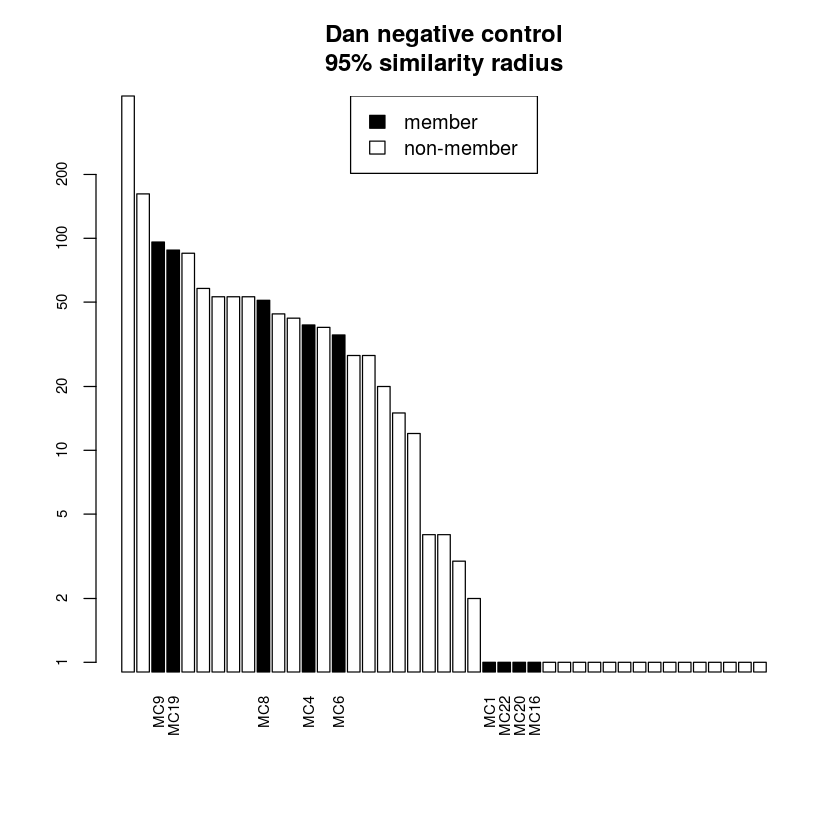

In [7]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))

In [13]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

svg(file='Dan_negative_21.06.2018.svg')
par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))
dev.off()

png 
  2

This new pipeline shows a few less low-abundance OTUs shared between the negative and positive controls, but the big picture is more or less the same. A fair amound of tag-switched reads, with the two most abundant tag-switched OTUs at around 100 reads. 

<a id='mock'><h3>Positive controls</h3></a>

Let's take a look at our genomic positive controls.

In [10]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosG')
dangen95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
dangen95 <- sort(dangen95, decreasing = TRUE)
length(dangen95)

[1] 58

In [19]:
save(dangen95, file='dangen95.rda')

24 species were intentionally put into the positive control. Here we detected 58. 

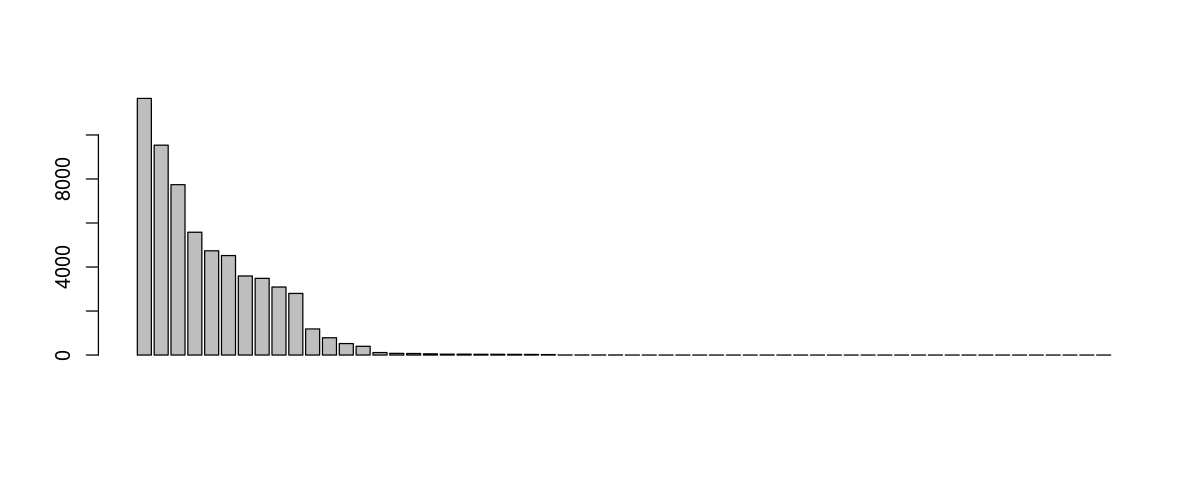

In [18]:
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(dangen95, names.arg='')

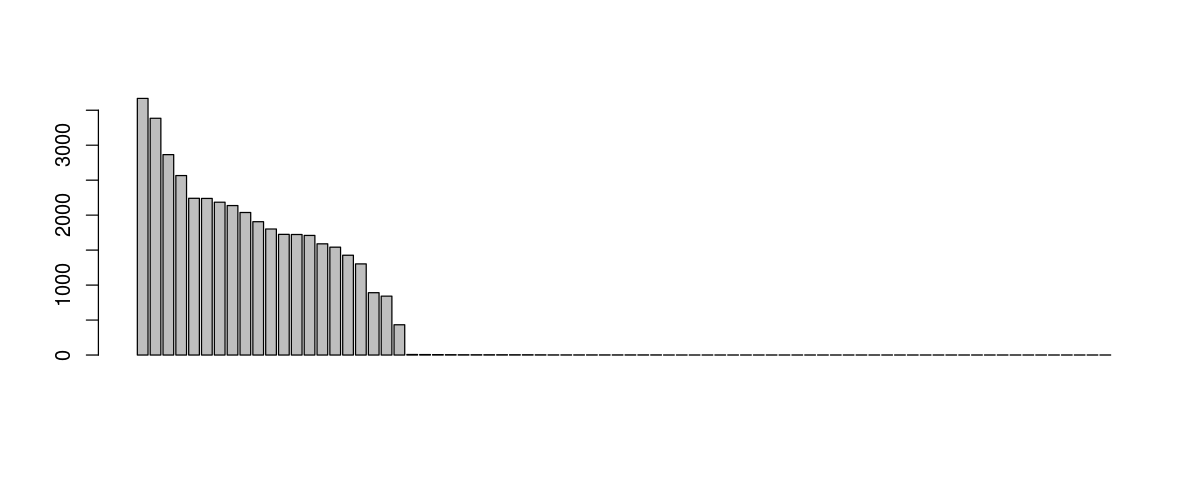

In [20]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosI')
danITS95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danITS95 <- sort(danITS95, decreasing = TRUE)
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(danITS95, names.arg='')

In [ ]:
save()

<a id='gPos'><h4>Genomic positive control</h4></a>

To show which of these are intended members of the mock community, not contaminants, we'll use the same kind of pipeline as we used above for the negative controls. Focus on the genomic positive control first, in which genomic DNA from all of our MC cultures were introduced in equal DNA concentrations into a single sample. 

In [3]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosG')
danGenreads <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danGenreads <- sort(danGenreads, decreasing = TRUE)
sink('danGenreads.txt') ## read out these OTUs so we can use them in python env
names(danGenreads)
sink()

[1] "OTU106:Dc-PosG"  "OTU119:Dc-PosG"  "OTU164:Dc-PosG"  "OTU191:Dc-PosG" 
 [5] "OTU220:Dc-PosG"  "OTU235:Dc-PosG"  "OTU258:Dc-PosG"  "OTU271:Dc-PosG" 
 [9] "OTU270:Dc-PosG"  "OTU358:Dc-PosG"  "OTU306:Dc-PosG"  "OTU264:Dc-PosG" 
[13] "OTU386:Dc-PosG"  "OTU526:Dc-PosG"  "OTU407:Dc-PosG"  "OTU256:Dc-X"    
[17] "OTU608:Dc-PosG"  "OTU826:Dc-PosG"  "OTU3183:Dc-PosG" "OTU3723:Dc-PosG"
[21] "OTU3674:Dc-PosG" "OTU12510:PosG"   "OTU4453:Dc-PosG" "OTU4210:Dc-PosG"
[25] "OTU733:Dc-PosG"  "OTU9035:Dc-PosG" "OTU1153:Dc-PosI" "OTU560:Dc-PosG" 
[29] "OTU8984:Dc-PosG" "OTU10988:PosG"   "OTU9833:Dc-PosI" "OTU248:20w"     
[33] "OTU18:9w"        "OTU610:1w"       "OTU257:3w"       "OTU12502:PosG"  
[37] "OTU8986:Dc-PosG" "OTU8401:Dc-PosG" "OTU152:1w"       "OTU77:1w"       
[41] "OTU28:2w"        "OTU249:1w"       "OTU5738:17w"     "OTU1075:100w"   
[45] "OTU391:2w"       "OTU1524:3w"      "OTU7955:106w"    "OTU5111:14w"    
[49] "OTU84:38w"       "OTU1124:36w"     "OTU1466:9w"      "OTU1214:9w"     
[53] "OTU1941:17w"     "OTU428:45w"      "OTU2567:130w"    "OTU1516:133w"   
[57] "OTU1866:133w"    "OTU12503:PosG"

The script to get the sequences of OTUs present in our illumina survey of our mock-community.

In [1]:
cat danGen_makeMCseq.py

mcseq=("OTU256:Dc-X","OTU306:Dc-PosG","OTU119:Dc-PosG","OTU220:Dc-PosG",
"OTU270:Dc-PosG","OTU191:Dc-PosG","OTU164:Dc-PosG","OTU235:Dc-PosG",
"OTU358:Dc-PosG","OTU106:Dc-PosG","OTU3674:Dc-PosG","OTU386:Dc-PosG",
"OTU271:Dc-PosG","OTU407:Dc-PosG","OTU258:Dc-PosG","OTU264:Dc-PosG",
"OTU4210:Dc-PosG","OTU1153:Dc-PosI","OTU8984:Dc-PosG","OTU526:Dc-PosG",
"OTU12510:PosG","OTU3723:Dc-PosG","OTU4453:Dc-PosG","OTU608:Dc-PosG",
"OTU3183:Dc-PosG","OTU826:Dc-PosG","OTU733:Dc-PosG","OTU8986:Dc-PosG",
"OTU9035:Dc-PosG","OTU8401:Dc-PosG","OTU560:Dc-PosG","OTU10988:PosG",
"OTU9833:Dc-PosI","OTU248:20w","OTU152:1w","OTU77:1w",
"OTU28:2w","OTU249:1w","OTU18:9w","OTU5738:17w",
"OTU610:1w","OTU1075:100w","OTU391:2w","OTU1524:3w",
"OTU257:3w","OTU7955:106w","OTU5111:14w","OTU84:38w",
"OTU1124:36w","OTU1466:9w","OTU1214:9w","OTU1941:17w",
"OTU428:45w","OTU2567:130w","OTU1516:133w","OTU1866:133w",
"OTU12502:PosG","OTU12503:PosG")

with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.rea

In [4]:
python3 danGen_makeMCseq.py

In [5]:
sed -i '/^>/ s/;size=.*//' seqs_dangen95.fasta 

blastn -query seqs_dangen95.fasta -db mcsanger.fasta -out mcblast_Dangen95.txt -num_descriptions 3 -num_alignments 3
blastn -query seqs_dangen95.fasta -db mcsanger.fasta -out mcblast_Dangen95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Dangen95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Dangen95.csv -i
sed 's/Sample//g' mcblast_Dangen95.csv -i

In [4]:
## change kernel to R
library('phyloseq')

In [2]:
blast <- read.csv("mcblast_Dangen95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU256:Dc-X,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU306:Dc-PosG,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU119:Dc-PosG,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU220:Dc-PosG,22,100.00,168,0,0,1,168,512,345,8e-88,311.0
OTU270:Dc-PosG,12,100.00,178,0,0,1,178,501,324,2e-93,329.0
OTU191:Dc-PosG,14,100.00,197,0,0,1,197,566,370,7e-104,364.0
OTU164:Dc-PosG,8,100.00,143,0,0,1,143,451,309,5e-74,265.0
OTU235:Dc-PosG,20,100.00,217,0,0,1,217,605,389,6e-115,401.0
OTU358:Dc-PosG,15,100.00,241,0,0,1,241,553,313,3e-128,446.0
OTU106:Dc-PosG,10,100.00,174,0,0,1,174,482,309,4e-91,322.0


In [5]:
blast <- read.csv("mcblast_Dangen95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU256:Dc-X,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU306:Dc-PosG,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU119:Dc-PosG,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU220:Dc-PosG,22,100.00,168,0,0,1,168,512,345,8e-88,311.0
OTU270:Dc-PosG,12,100.00,178,0,0,1,178,501,324,2e-93,329.0
OTU191:Dc-PosG,14,100.00,197,0,0,1,197,566,370,7e-104,364.0
OTU164:Dc-PosG,8,100.00,143,0,0,1,143,451,309,5e-74,265.0
OTU235:Dc-PosG,20,100.00,217,0,0,1,217,605,389,6e-115,401.0
OTU358:Dc-PosG,15,100.00,241,0,0,1,241,553,313,3e-128,446.0
OTU106:Dc-PosG,10,100.00,174,0,0,1,174,482,309,4e-91,322.0


Let's get rid of the short match, this is probably just a bit of the ssu or 5.8s.

In [6]:
goodblast <- blast[blast$length > 100,]

The sseqid column values are equivalent to numbers that we gave each DNA sample from our individual pure cultures. They go from MC1 to MC24, with sample MC21 skipped. 

In [7]:
1:24 %in% goodblast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

In [8]:
sort(unique(goodblast$sseqid)); length(unique(goodblast$sseqid))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24

[1] 22

As per last time, we are missing MC17, which corresponds to *Schizosaccaromyces pombe*.

Put together some info for a plot/dataframe

In [11]:
member <- names(dangen95) %in% goodblast$qseqid
MC <- vector(length = length(dangen95))
dangen95bar <- data.frame(cbind(dangen95, member, MC))
for (i in 1:nrow(dangen95bar)){
        if (rownames(dangen95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(dangen95bar)[i], goodblast$qseqid)
                dangen95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

In [12]:
head(dangen95bar)

,dangen95,member,MC
OTU106:Dc-PosG,11662,1,10
OTU119:Dc-PosG,9537,1,1
OTU164:Dc-PosG,7742,1,8
OTU191:Dc-PosG,5581,1,14
OTU220:Dc-PosG,4737,1,22
OTU235:Dc-PosG,4521,1,20


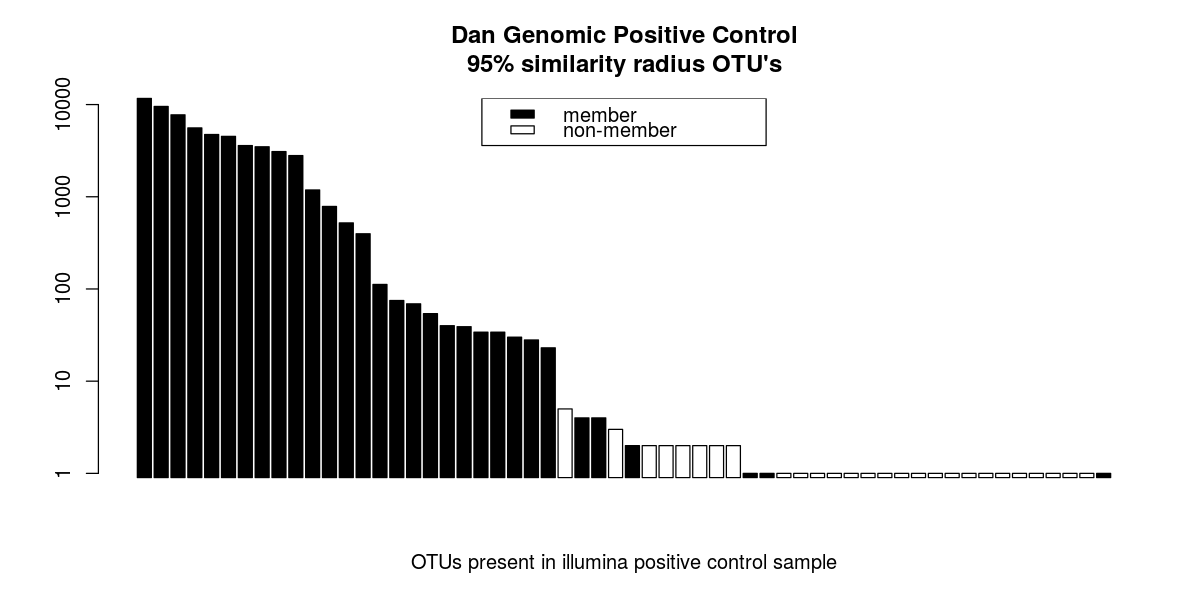

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(dangen95bar$dangen95, names.arg=NULL, col = dangen95bar$member,
        log="y", main="Dan Genomic Positive Control\n95% similarity radius OTU's",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

Log transformed. OTUs with no match to our sanger sequences are colored white. Notice that most of the rare OTUs are not members of our original mock community. They are presumably contaminants or the results of tag-switching.

How many of these MCs have been split?

In [14]:
dtab <- table(dangen95bar$MC)
dtab <- dtab[-1] #exclude non-members
dtab


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 
 4  1  1  1  1  1  1  5  1  1  1  1  2  1  1  2  1  1  1  1  1  1 

This table shows us that MC1,8,13,16 were split up by our bioinformatics. Let's visualize this, and compare to our other radius. For the plotter, get a matrix, each column representing our sanger-sequence sample numbers, and each row our otus in the illumina sample that matched to these sanger-sequences (MC#'s). 

In [15]:
stackmat <- matrix(nrow=max(dtab), ncol=24)
stackmat[] <- 0
stackmatnames <- paste("MC", 1:24, sep='')
colnames(stackmat) <- stackmatnames

for (i in 1:24){
        bb <- dangen95bar[dangen95bar$MC == i,, drop=FALSE]
        for (j in 1:nrow(bb)){stackmat[j,i] <- bb$dangen95[j]}
    }

In [16]:
stackmat <- stackmat[,-21] ## no MC21, wasn't put into MC mix
## sort by read abundances:
stackmat <- stackmat[,order(colSums(stackmat), decreasing = TRUE)]
stackmat

MC10,MC1,MC8,MC14,MC22,MC20,MC13,MC24,MC12,MC15,⋯,MC5,MC7,MC6,MC11,MC3,MC2,MC23,MC4,MC18,MC17
11662,9537,7742,5581,4737,4521,3593,3484,3090,2800,⋯,397,112,75,69,54,30,23,4,4,NA
0,39,40,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,34,34,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,28,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,2,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Now use this to plot our read abundances, to look at splitting of OTUs at this radius:

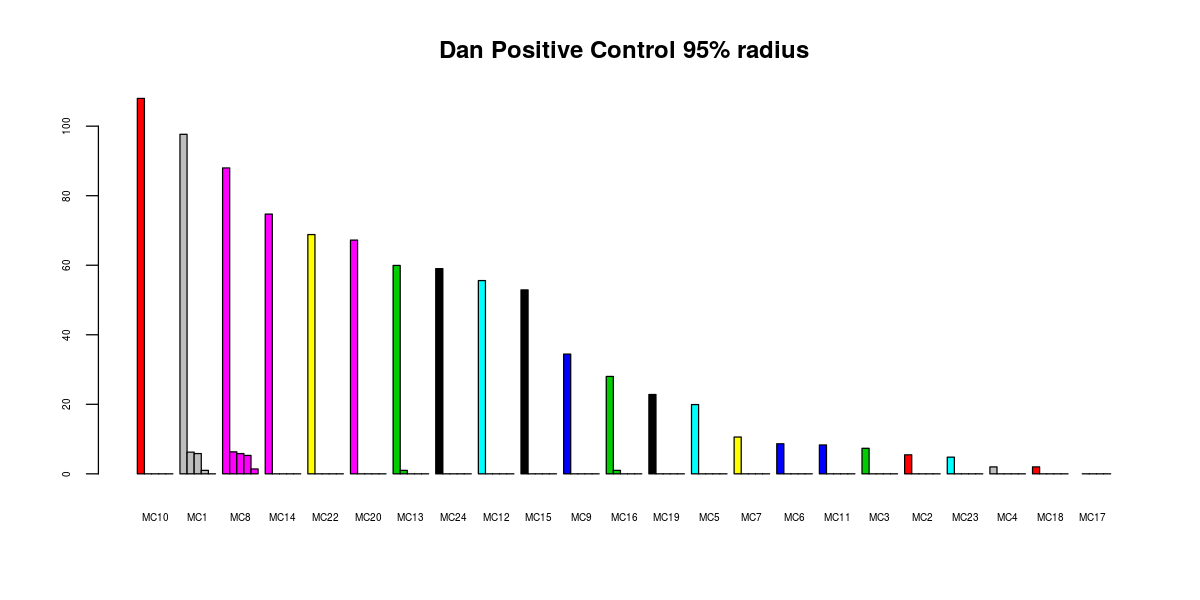

In [17]:
## make our colors from a palette. Randomize for better separation
bcols <- rep(sample(1:ncol(stackmat), replace=FALSE, size=23), each=nrow(stackmat))

par(cex.axis=.5)
## we can see our lower abundances better with sqrt:
barplot(sqrt(stackmat), beside = TRUE, col = bcols, main="Dan Positive Control 95% radius") 
par(mfrow=c(1,1))

Square root transformed axis, so abundance differences are quite large. MC1 is *Phaeocryptopus gaeumannii* and MC8 is a *Ramularia* sp.

<a id='iPos'><h4>ITS-only positive control</h4></a>

As a second positive control, we amplified the full ITS region of each our cultures from our mock community, then introduced equal concentrations of ITS PCR product into a single sample and put it in with the rest of the study. As per our genomic positive contol...

In [3]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosI')
danITSreads <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danITSreads <- sort(danITSreads, decreasing = TRUE)
sink('danITSreads.txt') ## read out these OTUs so we can use them in python env
names(danITSreads)
sink()

[1] "OTU256:Dc-X"      "OTU119:Dc-PosG"   "OTU106:Dc-PosG"   "OTU386:Dc-PosG"  
 [5] "OTU306:Dc-PosG"   "OTU264:Dc-PosG"   "OTU407:Dc-PosG"   "OTU191:Dc-PosG"  
 [9] "OTU270:Dc-PosG"   "OTU271:Dc-PosG"   "OTU220:Dc-PosG"   "OTU258:Dc-PosG"  
[13] "OTU526:Dc-PosG"   "OTU235:Dc-PosG"   "OTU560:Dc-PosG"   "OTU164:Dc-PosG"  
[17] "OTU608:Dc-PosG"   "OTU733:Dc-PosG"   "OTU358:Dc-PosG"   "OTU826:Dc-PosG"  
[21] "OTU1153:Dc-PosI"  "OTU4210:Dc-PosG"  "OTU3674:Dc-PosG"  "OTU12510:PosG"   
[25] "OTU3183:Dc-PosG"  "OTU3723:Dc-PosG"  "OTU4453:Dc-PosG"  "OTU10694:Dc-PosI"
[29] "OTU77:1w"         "OTU298:2w"        "OTU87:17w"        "OTU12521:Dc-PosG"
[33] "OTU8401:Dc-PosG"  "OTU12516:PosI"    "OTU1183:36w"      "OTU98:2w"        
[37] "OTU41:1w"         "OTU249:1w"        "OTU410:37w"       "OTU84:38w"       
[41] "OTU1520:30w"      "OTU8984:Dc-PosG"  "OTU8986:Dc-PosG"  "OTU7914:Dc-PosG" 
[45] "OTU9035:Dc-PosG"  "OTU10988:PosG"    "OTU9833:Dc-PosI"  "OTU186:1w"       
[49] "OTU471:5w"        "OTU192:1w"        "OTU28:2w"         "OTU1216:1w"      
[53] "OTU958:19w"       "OTU338:1w"        "OTU1292:32w"      "OTU18:9w"        
[57] "OTU6703:17w"      "OTU2954:1w"       "OTU161:2w"        "OTU387:2w"       
[61] "OTU2446:2w"       "OTU1279:15w"      "OTU2202:3w"       "OTU5187:68w"     
[65] "OTU250:4w"        "OTU1599:9w"       "OTU1973:131w"     "OTU3711:17w"     
[69] "OTU1612:18w"      "OTU6688:19w"      "OTU281:109w"      "OTU210:27w"      
[73] "OTU2860:70w"      "OTU839:57w"       "OTU2567:130w"     "OTU12503:PosG"

In [2]:
cat danITS_makeMCseq.py

mcseq=("OTU256:Dc-X","OTU119:Dc-PosG","OTU106:Dc-PosG","OTU386:Dc-PosG",
"OTU306:Dc-PosG","OTU264:Dc-PosG","OTU407:Dc-PosG","OTU191:Dc-PosG",
"OTU270:Dc-PosG","OTU271:Dc-PosG","OTU220:Dc-PosG","OTU258:Dc-PosG",
"OTU526:Dc-PosG","OTU235:Dc-PosG","OTU560:Dc-PosG","OTU164:Dc-PosG",
"OTU608:Dc-PosG","OTU733:Dc-PosG","OTU358:Dc-PosG","OTU826:Dc-PosG",
"OTU1153:Dc-PosI","OTU4210:Dc-PosG","OTU3674:Dc-PosG","OTU12510:PosG",
"OTU3183:Dc-PosG","OTU3723:Dc-PosG","OTU4453:Dc-PosG","OTU10694:Dc-PosI"
"OTU77:1w","OTU298:2w","OTU87:17w","OTU12521:Dc-PosG"
"OTU8401:Dc-PosG","OTU12516:PosI","OTU1183:36w","OTU98:2w",
"OTU41:1w","OTU249:1w","OTU410:37w","OTU84:38w",
"OTU1520:30w","OTU8984:Dc-PosG","OTU8986:Dc-PosG","OTU7914:Dc-PosG",
"OTU9035:Dc-PosG","OTU10988:PosG","OTU9833:Dc-PosI","OTU186:1w",
"OTU471:5w","OTU192:1w","OTU28:2w","OTU1216:1w",
"OTU958:19w","OTU338:1w","OTU1292:32w","OTU18:9w",
"OTU6703:17w","OTU2954:1w","OTU161:2w","OTU387:2w",
"OTU2446:2w","OTU1279:15w","OTU2202:3w","OTU5187:68w",
"OT

In [3]:
python3 danITS_makeMCseq.py

In [4]:
sed -i '/^>/ s/;size=.*//' seqs_danITS95.fasta 

blastn -query seqs_danITS95.fasta -db mcsanger.fasta -out mcblast_danITS95.txt -num_descriptions 3 -num_alignments 3
blastn -query seqs_danITS95.fasta -db mcsanger.fasta -out mcblast_danITS95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_danITS95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_danITS95.csv -i
sed 's/Sample//g' mcblast_danITS95.csv -i

Back to R...

In [3]:
blast <- read.csv("mcblast_danITS95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU256:Dc-X,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU119:Dc-PosG,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU106:Dc-PosG,10,100.00,174,0,0,1,174,482,309,4e-91,322.0
OTU386:Dc-PosG,19,100.00,175,0,0,1,175,513,339,1e-91,324.0
OTU306:Dc-PosG,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU264:Dc-PosG,16,100.00,180,0,0,1,180,502,323,2e-94,333.0
OTU407:Dc-PosG,7,100.00,193,0,0,1,193,524,332,1e-101,357.0
OTU191:Dc-PosG,14,100.00,197,0,0,1,197,566,370,7e-104,364.0
OTU270:Dc-PosG,12,100.00,178,0,0,1,178,501,324,2e-93,329.0
OTU271:Dc-PosG,24,100.00,209,0,0,1,209,537,329,2e-110,387.0


In [4]:
goodblast <- blast[blast$length > 100,]

Check MC presence/absence...

In [5]:
1:24 %in% goodblast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

In [6]:
sort(unique(goodblast$sseqid)); length(unique(goodblast$sseqid))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24

[1] 22

Still missing MC17.

In [12]:
member <- names(danITS95) %in% goodblast$qseqid ## danITS95 created above 
MC <- vector(length = length(danITS95))
danITS95bar <- data.frame(cbind(danITS95, member, MC))
for (i in 1:nrow(danITS95bar)){
        if (rownames(danITS95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(danITS95bar)[i], goodblast$qseqid)
                danITS95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

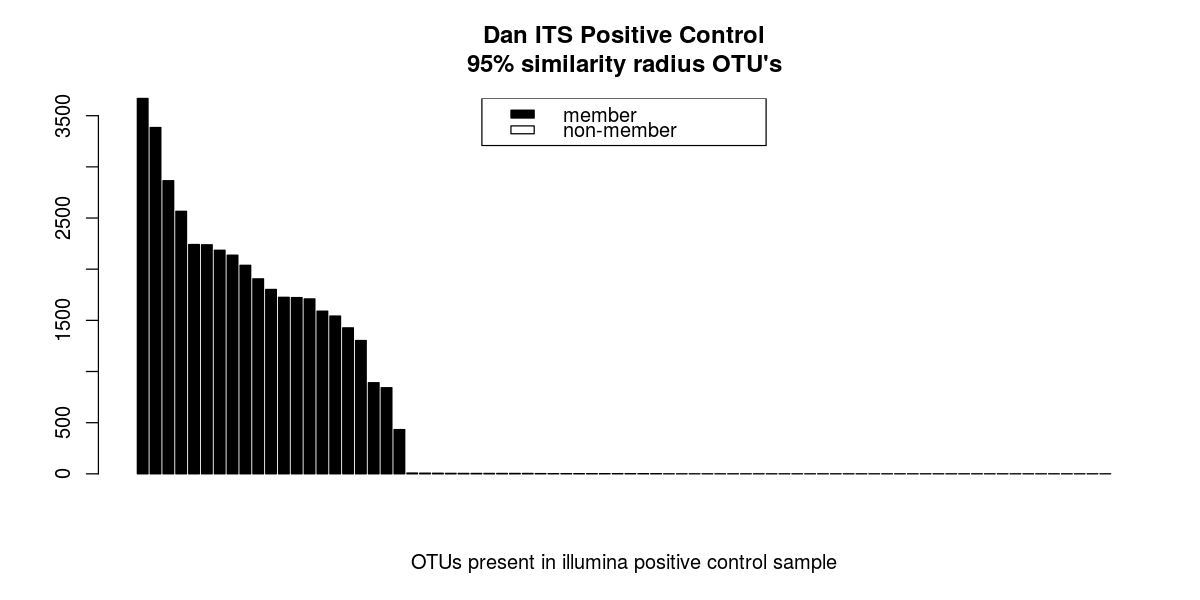

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(danITS95bar$danITS95, names.arg=NULL, col = danITS95bar$member,
        main="Dan ITS Positive Control\n95% similarity radius OTU's",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

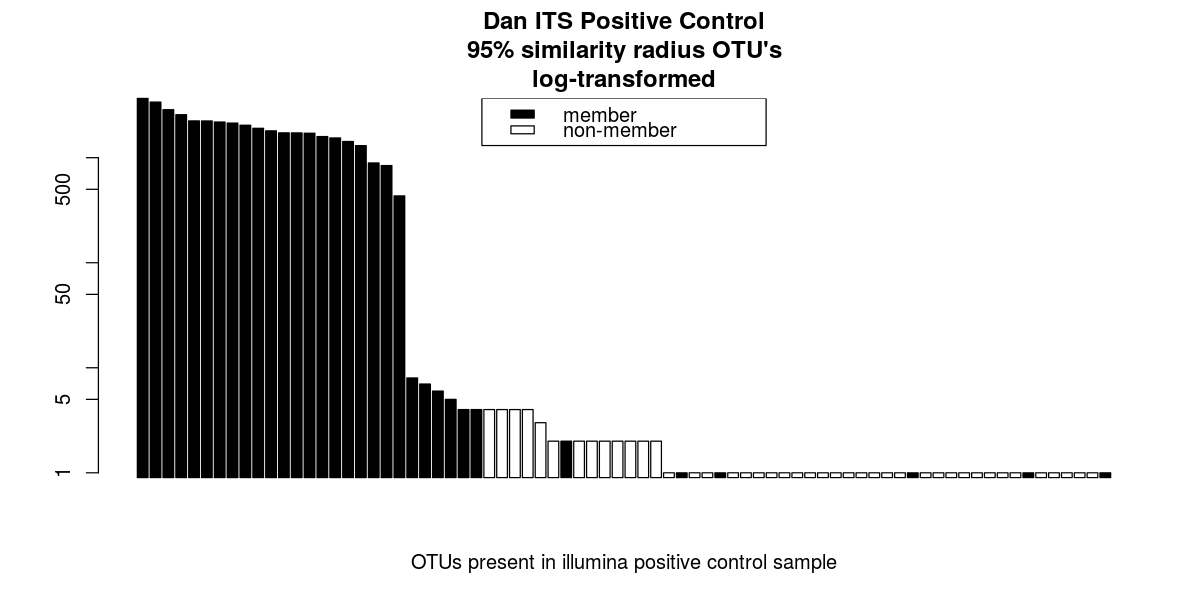

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(danITS95bar$danITS95, names.arg=NULL, col = danITS95bar$member,
        log="y", main="Dan ITS Positive Control\n95% similarity radius OTU's\nlog-transformed",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

Mostly intended members of the mock community were present... let's look at OTU splitting:

In [19]:
dtab <- table(danITS95bar$MC)
dtab <- dtab[-1] #exclude non-members
dtab


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 
 3  1  1  2  1  1  1  5  1  1  2  1  2  1  1  2  1  2  1  1  1  1 

Huh, seems like even more splitting in the ITS...

In [20]:
stackmat <- matrix(nrow=max(dtab), ncol=24)
stackmat[] <- 0
stackmatnames <- paste("MC", 1:24, sep='')
colnames(stackmat) <- stackmatnames

for (i in 1:24){
        bb <- danITS95bar[danITS95bar$MC == i,, drop=FALSE]
        for (j in 1:nrow(bb)){stackmat[j,i] <- bb$danITS95[j]}
    }

In [21]:
stackmat <- stackmat[,-21] ## no MC21, wasn't put into MC mix
## sort by read abundances:
stackmat <- stackmat[,order(colSums(stackmat), decreasing = TRUE)]
stackmat

MC6,MC1,MC10,MC19,MC9,MC16,MC7,MC14,MC12,MC24,⋯,MC20,MC4,MC8,MC11,MC23,MC15,MC3,MC18,MC2,MC17
3669,3385,2865,2566,2241,2239,2185,2137,2038,1906,⋯,1710,1590,1542,1427,1303,891,842,433,4,NA
0,7,0,1,0,1,0,0,0,0,⋯,0,2,8,1,0,0,0,0,0,0
0,4,0,0,0,0,0,0,0,0,⋯,0,0,6,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,5,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0


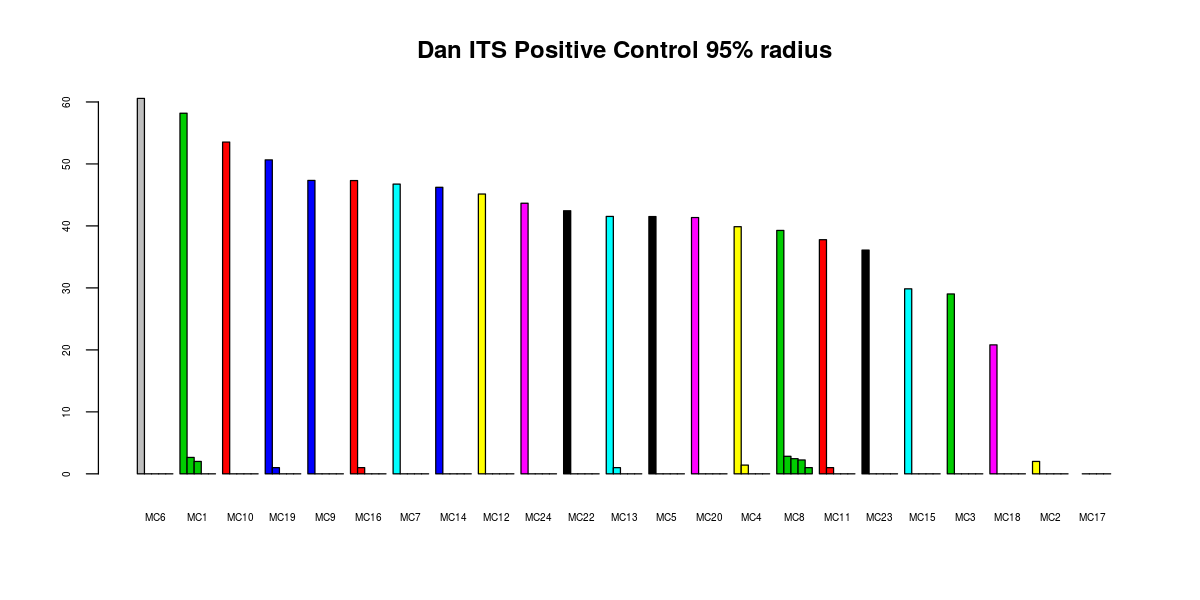

In [22]:
## make our colors from a palette. Randomize for better separation
bcols <- rep(sample(1:ncol(stackmat), replace=FALSE, size=23), each=nrow(stackmat))

par(cex.axis=.5)
## we can see our lower abundances better with sqrt:
barplot(sqrt(stackmat), beside = TRUE, col = bcols, main="Dan ITS Positive Control 95% radius") 
par(mfrow=c(1,1))

Same basic story, as far as OTU splitting.

<a id='cleanup'><h3>Cleanup using controls</h3></a>

We'll use our positive and negative controls to get estimates of rates of contamination and tag-switching, and institute cutoffs to reduce error from these sources. This is our pipeline for getting our reads ready to ask ecological questions. 

<a id='lowSamp'><h4>Removing low abundance samples:</h4></a>

In [24]:
sample_sums(biom95)[sample_sums(biom95) < 2000]

106leaf 112leafA 113leafA 113leafB 126leafB   18leaf   74leaf   86leaf 
       8       17       78       24       20     1648      341     1769 
  91leaf      Neg 
      12     1501

Looks like some of the leaf sites will be lost... Controls are low also, but we need to get rid of these anyway later.

In [37]:
biom95eco <- subset_samples(biom95, SorC=='Sample')
biom95eco_hiread <- prune_samples(sample_sums(biom95eco)>=2000, biom95eco)

In [38]:
biom95eco_hiread

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

<a id='minAbund'><h4>Minimum abundances of observations and contaminant removal</h4></a>

I define an observation as the presence of a OTU within a sample, regardless of read abundance. But to be acknowledged as a "real" observation, it is reasonable to ask that an observation meet a certain abundance, or we can throw it out. To address spurious OTUs that result from OTU-splitting, we can define this abundance threshold by looking a little more closely at our genomic positive and negative controls:

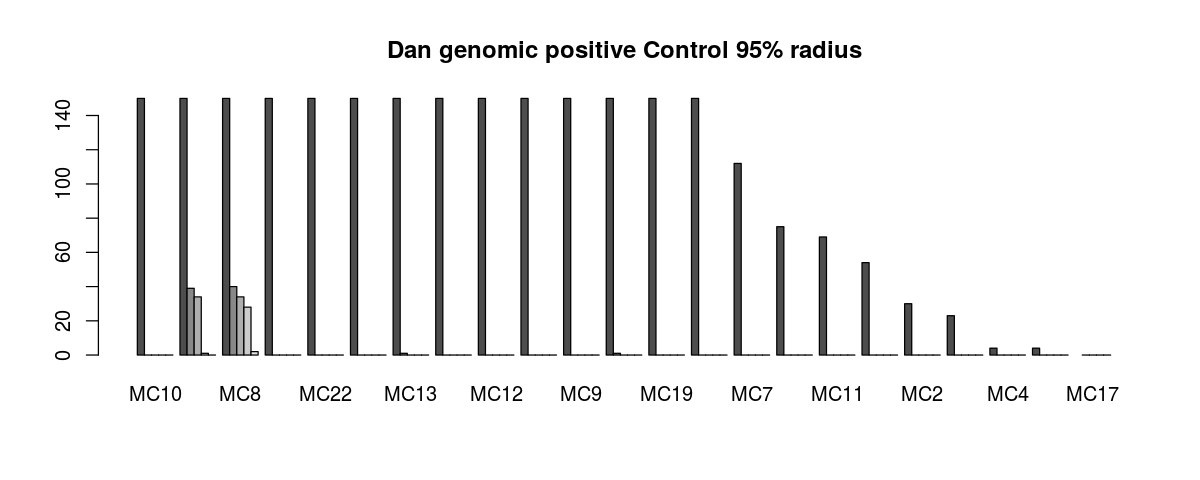

In [33]:
smShort <- stackmat ## rerun genomic control code above to get this. 
smShort[smShort > 150] <- 150
#save(smShort, file='posGtrun.rda')
barplot(smShort, beside = TRUE, main="Dan genomic positive Control 95% radius") 
par(mfrow=c(1,1))

In [32]:
svg(file='outsplitting_genomic.svg')
smShort <- stackmat ## rerun genomic control code above to get this. 
smShort[smShort > 150] <- 150
barplot(smShort, beside = TRUE, main="Dan genomic positive Control 95% radius") 
par(mfrow=c(1,1))
dev.off()

png 
  2

So to control for OTU splitting, looks like, in my positive control, most OTUs that are a result of splitting in the genomic positive control are at ~40 reads. For tag switching, if we look at the tagswitched OTUs in our negative control, we see that in our negative control that tag switching events seem to be ~100 reads or lower ([graph here](#NegGraph)):

In [102]:
Neg95bar[Neg95bar$member==TRUE,]

,reads,member,MC,Genus,Species
OTU306:Dc-PosG,96,TRUE,9,NoID,NoID
OTU386:Dc-PosG,88,TRUE,19,Nemania,Nemania_aenea_SH217392.07FU
OTU164:Dc-PosG,51,TRUE,8,Mycosphaerella,Mycosphaerella_rubella_SH206848.07FU
OTU560:Dc-PosG,39,TRUE,4,Diaporthe,Diaporthe_cynaroidis_SH090428.07FU
OTU256:Dc-X,35,TRUE,6,Trametes,NoID
OTU119:Dc-PosG,1,TRUE,1,Phaeocryptopus,NoID
OTU220:Dc-PosG,1,TRUE,22,NoID,NoID
OTU235:Dc-PosG,1,TRUE,20,Psilocybe,Psilocybe_cyanescens_SH262625.07FU
OTU264:Dc-PosG,1,TRUE,16,Xylaria,NoID


But I don't want to cut off observations at ~100 reads, we would lose a lot of information. This would begin to be as intellectually dishonest as doing no removal at all, erring too far in excluding real information from our results. As per our previous analysis, it seems about require a minimum threshold of 60 reads per observation in our wood samples. This eliminates all the observed events of OTU splitting, and 7 out of 9 tag switch events in our negative control. It also keeps us in line with our previous analysis. This threshold of 60 reads does eleminate the 7 lowest-abundance members of our 22 detected members of the mock community, indicating a large loss of information. Always a trade-off. 

As per our previous analysis, we'll scale up the number of leaf reads to be proportionate. To quote myself:

>We have no positive controls from the leaf data, since Roo sequenced those in a separate study, so for now we'll assume that these samples have a +/- similar level of error from tag-switching. To figure the level of subtraction for tag-switching and splinter OTUs in his study, we'll subtract the same proportion of reads/library as the wood. Relative to the total number of reads (4,521,655) in the wood library, this is a reduction in each OTU/sample observation of 60/4,521,655 = 0.000013269 times the library size. If we multiply the size of the leaf library by this, we get (0.000013269)x(10,751,750 reads) = 142.6972, or 143 reads. 

We'll round to 140 reads.

In addition, this is a good time to remove the contaminants we find in our controls, while the leaf and wood abundances are being considered separately. We're going to remove all of our mock community members from wherever they appear in the study in a downstream step anyway (see below), so we can treat our positive controls just like negatives here, removing all that we find.

Split the OTU abundance table into leaf and wood libraries:

In [204]:
leafeco <- subset_samples(biom95eco_hiread, Library=='L')
woodeco <- subset_samples(biom95eco_hiread, Library=='W')

Wood reads:

In [205]:
## what are the maximums from our controls?:

woodControls <- prune_samples(sample_names(biom95)=='Neg' |
                              sample_names(biom95)=='PosG' |
                              sample_names(biom95)=='PosI',
                              biom95)

## get maximums
woodContam <- apply(otu_table(woodControls), 1, max)

## how many control OTUs are there?
sum(woodContam>0)

[1] 122

In [218]:
sort(woodContam[woodContam > 0])

OTU8986:Dc-PosG  OTU7914:Dc-PosG        OTU186:1w        OTU471:5w 
               1                1                1                1 
        OTU64:1w        OTU192:1w        OTU409:4w        OTU152:1w 
               1                1                1                1 
        OTU28:2w       OTU1216:1w       OTU958:19w        OTU437:1w 
               1                1                1                1 
       OTU338:1w      OTU1292:32w      OTU5738:17w       OTU414:13w 
               1                1                1                1 
     OTU6703:17w        OTU655:1w       OTU2954:1w     OTU1075:100w 
               1                1                1                1 
       OTU161:2w        OTU391:2w       OTU2029:2w        OTU387:2w 
               1                1                1                1 
      OTU2446:2w      OTU1279:15w       OTU2202:3w      OTU5187:68w 
               1                1                1                1 
       OTU250:4w       OTU1524:3w     OTU7955:106w     OTU1973:131w 
               1                1                1                1 
     OTU5111:14w      OTU1124:36w      OTU7329:38w       OTU1466:9w 
               1                1                1                1 
     OTU925:133w      OTU1941:17w      OTU3711:17w      OTU1612:18w 
               1                1                1                1 
     OTU6688:19w      OTU1496:23w       OTU588:32w      OTU1888:25w 
               1                1                1                1 
     OTU281:109w       OTU210:27w      OTU2860:70w       OTU428:45w 
               1                1                1                1 
      OTU839:57w     OTU2567:130w      OTU972:130w     OTU1516:133w 
               1                1                1                1 
    OTU1866:133w    OTU12503:PosG  OTU8401:Dc-PosG    OTU10988:PosG 
               1                1                2                2 
   OTU12516:PosI  OTU9833:Dc-PosI      OTU1183:36w       OTU248:20w 
               2                2                2                2 
        OTU98:2w         OTU41:1w        OTU249:1w         OTU18:9w 
               2                2                2                2 
       OTU610:1w        OTU257:3w       OTU410:37w      OTU1520:30w 
               2                2                2                2 
    OTU2115:131w    OTU12502:PosG  OTU8984:Dc-PosG OTU12521:Dc-PosG 
               2                2                3                3 
       OTU46:60w OTU10694:Dc-PosI         OTU77:1w        OTU298:2w 
               3                4                4                4 
      OTU1599:9w       OTU2831:5w        OTU87:17w  OTU9035:Dc-PosG 
               4                4                4                5 
       OTU84:38w        OTU417:1w      OTU6852:Neg  OTU4210:Dc-PosG 
              12               15               20               28 
      OTU1432:2w     OTU1549:104w  OTU4453:Dc-PosG  OTU3674:Dc-PosG 
              28               28               30               34 
   OTU12510:PosG      OTU1444:49w  OTU3723:Dc-PosG  OTU3183:Dc-PosG 
              34               38               39               40 
     OTU2003:Neg      OTU1332:11w      OTU762:Dc-X       OTU1214:9w 
              42               44               53               53 
     OTU1747:11w        OTU891:1w   OTU187:Dc-PosG        OTU315:4w 
              53               58               85              162 
 OTU1153:Dc-PosI      OTU167:Dc-X   OTU826:Dc-PosG   OTU733:Dc-PosG 
             433              469              842             1303 
  OTU608:Dc-PosG   OTU560:Dc-PosG   OTU526:Dc-PosG   OTU407:Dc-PosG 
            1427             1590             1723             2185 
  OTU264:Dc-PosG   OTU306:Dc-PosG   OTU386:Dc-PosG   OTU358:Dc-PosG 
            2239             2241             2566             2800 
  OTU270:Dc-PosG   OTU271:Dc-PosG   OTU258:Dc-PosG      OTU256:Dc-X 
            3090             3484             3593             3669 

In [206]:
## just checking...
length(woodContam); all(names(woodContam) == rownames(otu_table(woodeco)))

[1] 11588

[1] TRUE

In [207]:
woodCotu <- otu_table(woodeco) - woodContam ## subtract contaminants
woodCotu <- woodCotu-60 ## subtract minimum threshold
woodCotu[woodCotu < 0] <- 0 ## bring negatives up to zero
woodeco.contam.rem <- woodeco ## make a copy, just in case
otu_table(woodeco.contam.rem) <- woodCotu ## insert the corrected OTU

Now leaf reads, subtract contaminants and minimum threshold:

In [208]:
## what are the maximums from our controls?:

leafControls <- prune_samples(sample_names(biom95)=='leafNCA' |
                              sample_names(biom95)=='leafNCB',
                              biom95)

## get maximums
leafContam <- apply(otu_table(leafControls), 1, max)

## how many control OTUs are there?
sum(leafContam>0)

[1] 89

In [209]:
## just checking...
length(leafContam); all(names(leafContam) == rownames(otu_table(leafeco)))

[1] 11588

[1] TRUE

In [210]:
leafCotu <- otu_table(leafeco) - leafContam ## subtract contaminants
leafCotu <- leafCotu-140 ## subtract minimum threshold
leafCotu[leafCotu < 0] <- 0 ## bring negatives up to zero
leafeco.contam.rem <- leafeco ## make a copy, just in case
otu_table(leafeco.contam.rem) <- leafCotu ## insert the corrected OTU

Okay, now reunite the leaf and wood reads:

In [211]:
## does "merging" work here to bring these back together?
biom95.mend <- merge_phyloseq(woodeco.contam.rem,leafeco.contam.rem)

In [253]:
#save(biom95.mend, file="biom95.mend.rda")

Run some checks:

In [243]:
## check to make sure structure is intact
dim(otu_table(biom95eco_hiread))
dim(otu_table(biom95.mend))

[1] 11588   214

[1] 11588   214

In [244]:
## row and column order changed after merging?
all(rownames(otu_table(biom95.mend)) %in% rownames(otu_table(biom95eco_hiread)))
all(colnames(otu_table(biom95.mend)) %in% colnames(otu_table(biom95eco_hiread)))

all(rownames(otu_table(biom95eco_hiread)) %in%  rownames(otu_table(biom95.mend)))
all(colnames(otu_table(biom95eco_hiread) %in% colnames(otu_table(biom95.mend))))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [245]:
## dup tables
aa <- otu_table(biom95eco_hiread); bb <- otu_table(biom95.mend)
## reorder columns so they match, for spot checking the matrices
eco_reord <- aa[,order(colnames(aa))]; mend_reord <- bb[,order(colnames(bb))]

In [246]:
## spot check
eco_reord[1:5,1:5]
mend_reord[1:5,1:5] ## should be lower, more zeroes but no negs

,100leaf,100w,101leaf,101w,102leaf
OTU19:100leaf,81511,0,178,0,0
OTU108:100leaf,26184,0,0,0,0
OTU1:100leaf,2735,0,6795,0,586
OTU202:100leaf,3214,0,0,0,0
OTU426:100leaf,5943,0,0,0,0


,100leaf,100w,101leaf,101w,102leaf
OTU19:100leaf,81371,0,38,0,0
OTU108:100leaf,26044,0,0,0,0
OTU1:100leaf,2594,0,6654,0,445
OTU202:100leaf,3074,0,0,0,0
OTU426:100leaf,5803,0,0,0,0


In [110]:
## spot check
eco_reord[1:5,1:5]
mend_reord[1:5,1:5] ## should be lower, more zeroes but no negs

,100leaf,100w,101leaf,101w,102leaf
OTU19:100leaf,81511,0,178,0,0
OTU108:100leaf,26184,0,0,0,0
OTU1:100leaf,2735,0,6795,0,586
OTU202:100leaf,3214,0,0,0,0
OTU426:100leaf,5943,0,0,0,0


,100leaf,100w,101leaf,101w,102leaf
OTU19:100leaf,81371,0,38,0,0
OTU108:100leaf,26044,0,0,0,0
OTU1:100leaf,2595,0,6655,0,446
OTU202:100leaf,3074,0,0,0,0
OTU426:100leaf,5803,0,0,0,0


In [111]:
## more spot checks
eco_reord[5140:5145,172:177]
mend_reord[5140:5145,172:177]

,76w,77leaf,78leaf,79leaf,79w,7leaf
OTU1101:Dc-Neg,0,0,0,0,0,0
OTU1517:Dc-Neg,0,0,0,0,0,0
OTU351:Dc-Neg,6945,0,0,0,0,0
OTU1562:Dc-Neg,0,0,0,0,0,0
OTU1227:Dc-Neg,0,0,0,0,11,0
OTU1949:Dc-Neg,0,0,0,0,0,0


,76w,77leaf,78leaf,79leaf,79w,7leaf
OTU1101:Dc-Neg,0,0,0,0,0,0
OTU1517:Dc-Neg,0,0,0,0,0,0
OTU351:Dc-Neg,6885,0,0,0,0,0
OTU1562:Dc-Neg,0,0,0,0,0,0
OTU1227:Dc-Neg,0,0,0,0,0,0
OTU1949:Dc-Neg,0,0,0,0,0,0


In [82]:
## more spot checks
eco_reord[5140:5145,172:177]
mend_reord[5140:5145,172:177]

,76w,77leaf,78leaf,79leaf,79w,7leaf
OTU1101:Dc-Neg,0,0,0,0,0,0
OTU1517:Dc-Neg,0,0,0,0,0,0
OTU351:Dc-Neg,6945,0,0,0,0,0
OTU1562:Dc-Neg,0,0,0,0,0,0
OTU1227:Dc-Neg,0,0,0,0,11,0
OTU1949:Dc-Neg,0,0,0,0,0,0


,76w,77leaf,78leaf,79leaf,79w,7leaf
OTU1101:Dc-Neg,0,0,0,0,0,0
OTU1517:Dc-Neg,0,0,0,0,0,0
OTU351:Dc-Neg,6885,0,0,0,0,0
OTU1562:Dc-Neg,0,0,0,0,0,0
OTU1227:Dc-Neg,0,0,0,0,0,0
OTU1949:Dc-Neg,0,0,0,0,0,0


In [80]:
## more spot checks
eco_reord[1140:1150,120:130]
mend_reord[1140:1150,120:130]

,49w,4leaf,4w,50leaf,50w,51leaf,52leaf,52w,53leaf,54leaf,55leaf
OTU9024:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU10740:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU10278:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU9776:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU2355:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU9034:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU51:109leaf,0,0,0,13568,0,6203,0,0,0,496,0
OTU8420:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU8927:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU11707:109leaf,0,0,0,0,0,0,0,0,0,0,0


,49w,4leaf,4w,50leaf,50w,51leaf,52leaf,52w,53leaf,54leaf,55leaf
OTU9024:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU10740:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU10278:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU9776:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU2355:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU9034:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU51:109leaf,0,0,0,13428,0,6063,0,0,0,356,0
OTU8420:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU8927:109leaf,0,0,0,0,0,0,0,0,0,0,0
OTU11707:109leaf,0,0,0,0,0,0,0,0,0,0,0


To check our contaminant removal: wood otus that are contaminants should be 60 + highest abundance found in any of the three wood controls. For instance, OTU315:4w is a contaminant found in our negative control:

In [240]:
otu_table(woodControls)["OTU315:4w",]

,Neg,PosG,PosI
OTU315:4w,162,0,0


This means that after our thresholds and subtraction of negative control abundances we should see a 162+60=222 read loss where ever OTU315:4w is observed in wood samples (or 162+140=302 read loss for leaves):

In [242]:
aa <- t(rbind(eco_reord['OTU315:4w',],mend_reord['OTU315:4w',]))
colnames(aa) <- c('before cleanup', 'after cleanup')
aa[rowSums(aa) > 0,]

,before cleanup,after cleanup
102w,18,0
10w,3,0
11w,16,0
121w,2,0
130w,14,0
14w,1,0
16w,1,0
17w,8,0
18w,1,0
19w,3612,3390


Looks like the cleanup worked as intended. 

<a id='remMCs'><h3>Remove all mock community OTUs</h3></a>

Unfortunately, it looks like our mock community bled out quite a lot into our other samples. So I can't really trust any OTUs that match to our positive controls, any observations of these OTUs could well be the result of tag switching. To get rid of them, we'll use the same basic method as above when identifying which OTUs were members of the mock community. But this time we'll blast our entire set of OTUs against our list of sanger sequences for the positive control. Any strong hits will be considered as possibly resulting from tag-switching, and will be removed. 

In [1]:
## clean up our cluster names a little
sed '/>OTU/ s/;size=.*//g' otus_95_combo_nolb.fasta > otus_95.fasta

In [2]:
blastn -query otus_95.fasta -db mcsanger.fasta -out mcblast_allOTUs.csv -outfmt 10 -max_target_seqs 1

Read this into R, assign some column names.

In [4]:
## pick the biom tables back up into workspace
load("biom95.mend.rda") 
load('biom95.rda')

In [8]:
blast <- read.csv('mcblast_allOTUs.csv', header=FALSE)
blasthead <- c('qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore')
colnames(blast) <- blasthead

In [10]:
head(blast); dim(blast)

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU3:leafNotChim_102,Sample1_ITS4,87.67,146,16,1,1,146,307,450,4e-45,169.0
OTU10:leafNotChim_100,Sample15_ITS4,86.94,245,19,10,3,239,330,569,3e-73,263.0
OTU16:leafNotChim_100,Sample15_ITS4,86.90,229,16,10,20,240,347,569,1e-67,244.0
OTU20:leafNotChim_108,Sample16_ITS4,88.57,70,5,1,89,155,449,518,6e-19,82.4
OTU21:leafNotChim_112B,Sample1_ITS4,85.71,147,14,7,2,144,307,450,5e-39,148.0
OTU33:Dc-X,Sample16_ITS4,95.24,63,3,0,1,63,502,440,2e-24,100.0


[1] 769  12

In [13]:
## keep only strong matches
goodblast <- blast[blast$pident > 95 & blast$length > 100,] 

In [14]:
nrow(blast) 
nrow(goodblast)

[1] 769

[1] 54

769 otus matched somehow to an MC sequence, but only 54 OTUs are strong matches, so these are the ones to get rid of. 

In [15]:
## which of our rownames (= OTU names) are not in this list of strong matches?
pcotus <- !(rownames(otu_table(biom95)) %in% goodblast$qseqid) 
## keep only these:
biom95.mc.rem <- prune_taxa(pcotus, biom95.mend)

In [16]:
#save(biom95.mc.rem, file='biom95.mc.rem.rda')

Check the losses in reads, samples, etc:

In [17]:
biom95; biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11553 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11553 taxa by 7 taxonomic ranks ]

In [18]:
sum(sample_sums(biom95))
sum(sample_sums(biom95.mc.rem))

[1] 15442054

[1] 13189412

2,252,642 reads removed by the cleanup from controls. How many observations were lost?

In [19]:
sum(otu_table(biom95) > 0)
sum(otu_table(biom95.mc.rem) > 0)

[1] 51625

[1] 9684

41941 observations removed, ~80% of all observations... that's a lot. 

How many taxa removed entirely from the study?

In [29]:
sum(rowSums(otu_table(biom95)) > 0)

sum(rowSums(otu_table(biom95.mc.rem)) > 0)

[1] 11588

[1] 3330

That's a lot. Oh well. Onward. 

<a id='varstab'><h2>Variance stabilization of reads</h2></a>

<a id='DESeq2'><h3>Apply DESeq2 algorithms</h3></a>

Let's stabilize the variance among our samples using DESeq2. Let's use Roo's old script for doing this, hope it still works after three years...

In [32]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL
        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)
        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }
        geo_Means = apply(counts(deseq), 1, gm_mean)
        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on
                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)
                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0
                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)
                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq
                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)
                # return the new phyloseq object
                return(phyloseq.DESeq)
        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}
} # end function


In [33]:
deseq95 <- DESeq_varstab(biom95.mc.rem, ~Library)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


In [34]:
#save(deseq95, file='deseq95.rda')

In [35]:
deseq95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3327 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3327 taxa by 7 taxonomic ranks ]

In [36]:
biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11553 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11553 taxa by 7 taxonomic ranks ]

Looks like a big drop in taxa, but not really. Most of these taxa-rows, were emptied out during our cleanup from the controls. We really only lost 3330 - 3327 = 3 otus. 

<a id='BAvarstab'><h3>Compare pre/post variance-stabilization distibutions</h3></a>


<h4>Overall distributions of reads among leaf/wood samples:</h4>

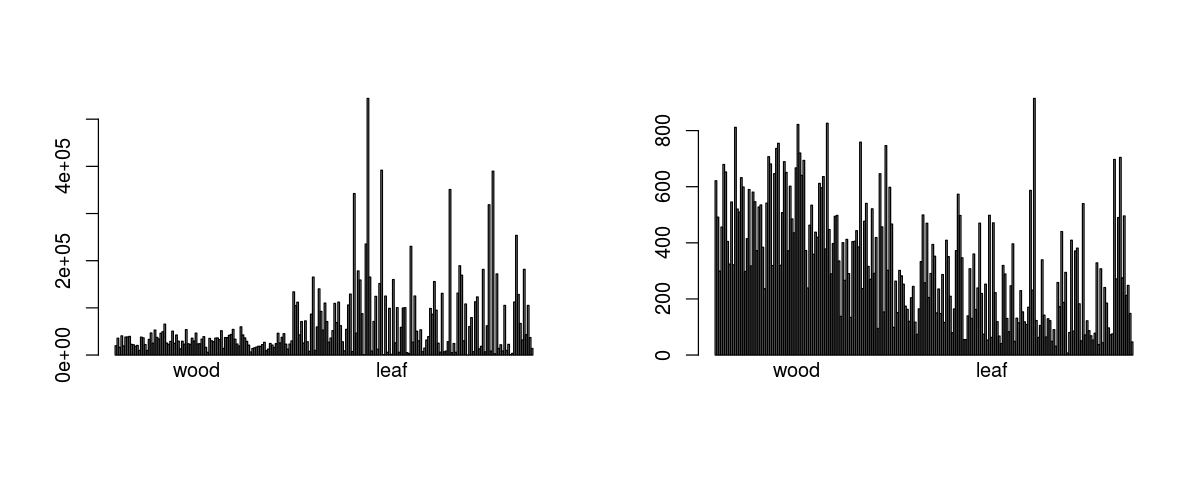

In [38]:
par(mfrow = c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

barplot(sample_sums(biom95.mc.rem), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

barplot(sample_sums(deseq95), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

<h4>Positive controls after variance stabilization</h4>

In [72]:
aa <- biom95
#bb <- DESeq_varstab(biom95, ~Library)

aaOTU <- (otu_table(aa)[,'PosG']) ## our control, before
aaOTU <- aaOTU[aaOTU != 0]

bbOTU <- (otu_table(bb)[,'PosG']) ## our control, after
bbOTU <- bbOTU[bbOTU != 0]

rownames(aaOTU) %in% rownames(bbOTU) ## did we lose any?

## tag them for plotting and comparison
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'PosG'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'PosG'], decreasing = TRUE),]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

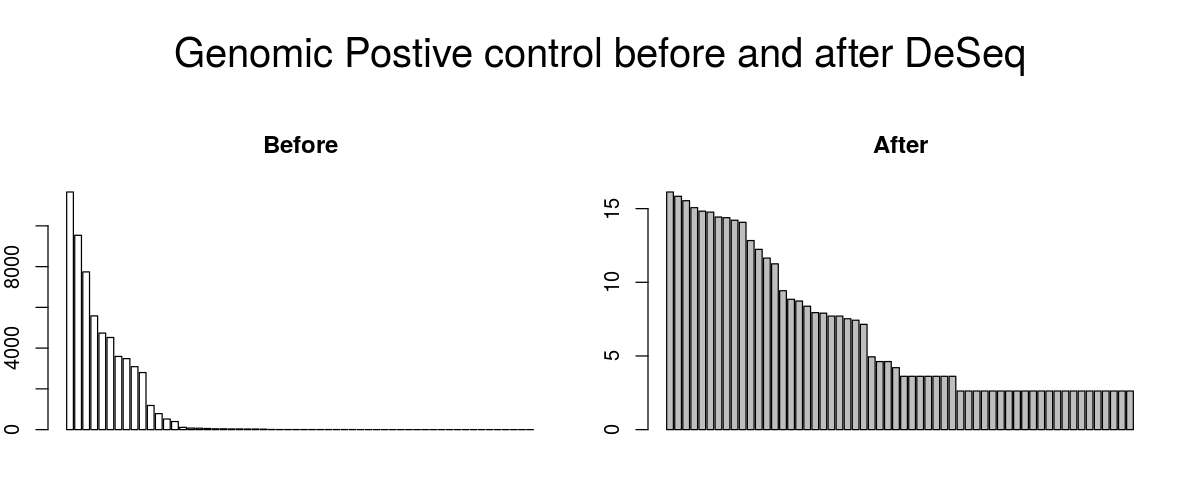

In [73]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'PosG'],
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'PosG']),
       main = 'After',
       )

mtext("Genomic Postive control before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

How about the ITS-only positive control? Use the same pipeline...

In [75]:
#aa <- biom95
#bb <- DESeq_varstab(biom95, ~Library)
aaOTU <- (otu_table(aa)[,'PosI']) ## our control, before
aaOTU <- aaOTU[aaOTU != 0]

bbOTU <- (otu_table(bb)[,'PosI']) ## our control, after
bbOTU <- bbOTU[bbOTU != 0]

rownames(aaOTU) %in% rownames(bbOTU) ## did we lose any?

## tag them for plotting and comparison
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'PosI'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'PosI'], decreasing = TRUE),]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[76] TRUE

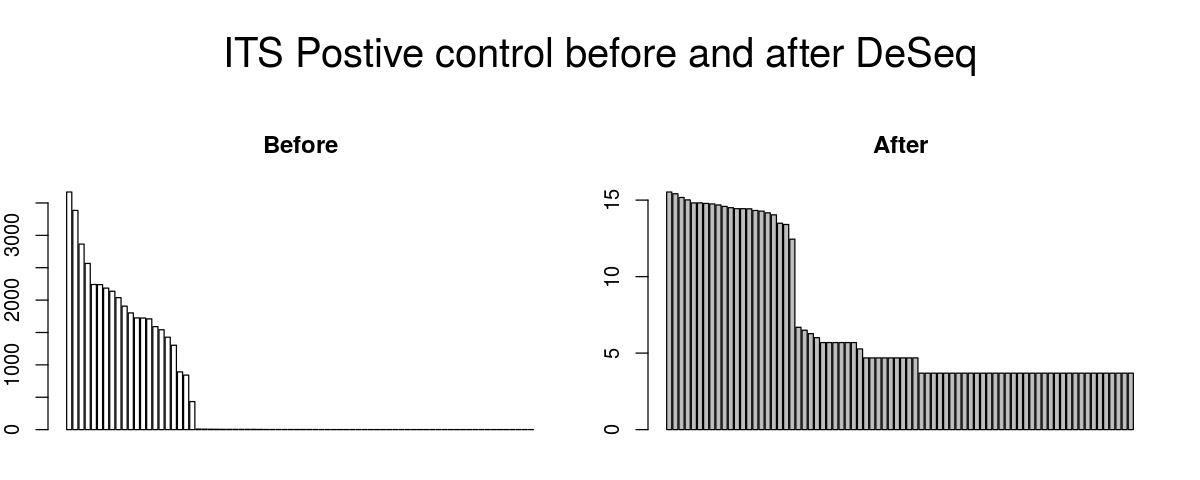

In [76]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'PosI'],
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'PosI']),
       main = 'After',
       )

mtext("ITS Postive control before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

If we get time, color these in with membership of the mock community. 

<h4>Ecological samples after variance stabilization</h4>

In [54]:
load('biom95.mc.rem.rda')
aa <- biom95.mc.rem
load('deseq95.rda')
bb <- deseq95

aaOTU <- (otu_table(aa)[,'1w'])
aaOTU <- aaOTU[aaOTU != 0]
bbOTU <- (otu_table(bb)[,'1w'])
bbOTU <- bbOTU[bbOTU != 0]
rownames(aaOTU) %in% rownames(bbOTU) 
## let's tag these, plot them
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))*1
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'1w'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'1w'], decreasing = TRUE),]


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

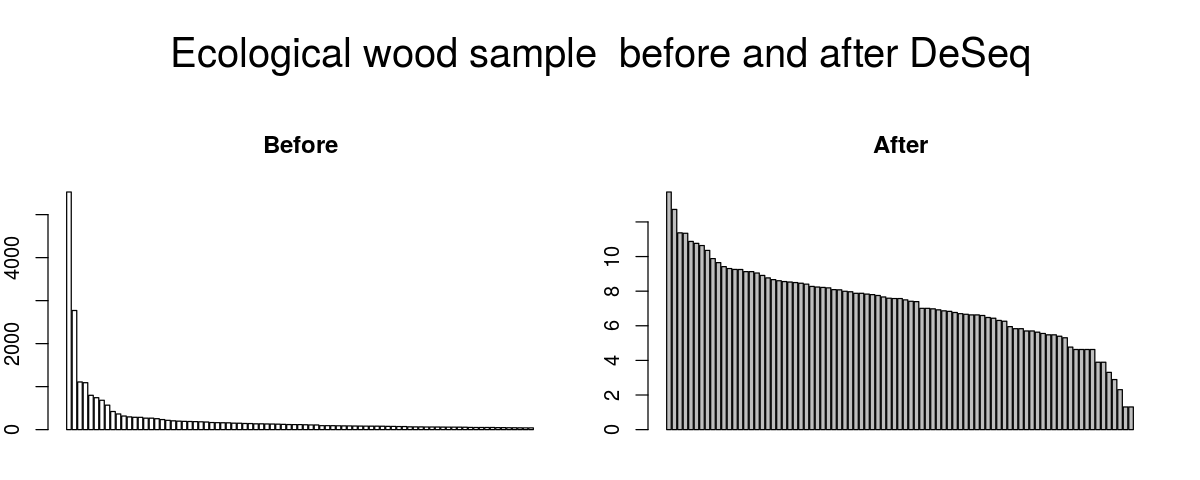

In [56]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'1w']+40, ## add some to make visible
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'1w']),
       main = 'After',
       )

mtext("Ecological wood sample  before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

Huh, unlike in our last analysis, we didn't lose our rare OTUs. I'm not sure why/what was different in the case. Generally, though, the transformation here is pretty clean. As before, deseq's algorithmns improve but don't completely ameliorate the issues of uneven amplification and sequencer detection. 

Ideally, one should be able to train an algorithm based on performance with a series of positive controls. I can imagine this being part of the future of hi-throughput metabarcoding pipelines. 

<a id='NMSs'><h2>NMS/PERMANOVA Ordinations</h2></a>

<a id='WvLNMS'><h3>Wood vs. Leaf librariesWood vs. Leaf libraries, all reads</h3><a>

In [80]:
## get two otu tables out, one for all wood samples, one for all leaf samples:
woodOTU <- otu_table(subset_samples(deseq95, Library=='W'))
wood <- t(woodOTU@.Data) ## transpose so samples are rows

leafOTU <- otu_table(subset_samples(deseq95, Library=='L'))
leaf <- t(leafOTU@.Data) ## transpose so samples are rows

In [81]:
dim(wood); dim(leaf) ## note this 
nmsmat <- rbind(wood, leaf)

[1]   91 3327

[1]  123 3327

In [85]:
save(nmsmat, file='nmsmat.rda')

In [82]:
WvsL <- metaMDS(nmsmat)

Wisconsin double standardization
Run 0 stress 0.0001791434 
Run 1 stress 0.0002137209 
... Procrustes: rmse 0.0001871009  max resid 0.002720356 
... Similar to previous best
Run 2 stress 0.0001897826 
... Procrustes: rmse 0.0002596393  max resid 0.003777302 
... Similar to previous best
Run 3 stress 0.0002119864 
... Procrustes: rmse 2.941868e-05  max resid 0.0003928597 
... Similar to previous best
Run 4 stress 0.0002037484 
... Procrustes: rmse 2.253602e-05  max resid 0.0002837903 
... Similar to previous best
Run 5 stress 0.0001947748 
... Procrustes: rmse 7.080397e-05  max resid 0.001015304 
... Similar to previous best
Run 6 stress 0.0001851663 
... Procrustes: rmse 0.000251969  max resid 0.003664053 
... Similar to previous best
Run 7 stress 0.0001863611 
... Procrustes: rmse 0.0002514439  max resid 0.003658659 
... Similar to previous best
Run 8 stress 0.0001810524 
... Procrustes: rmse 0.0002002467  max resid 0.00290918 
... Similar to previous best
Run 9 stress 0.0001733723 
.

Warning message in metaMDS(nmsmat):
“stress is (nearly) zero: you may have insufficient data”

In [83]:
## make a color vector, leaves green, wood brown:
color <- NULL
color[1:91] <- 'brown'
color[92:214] <- 'green'

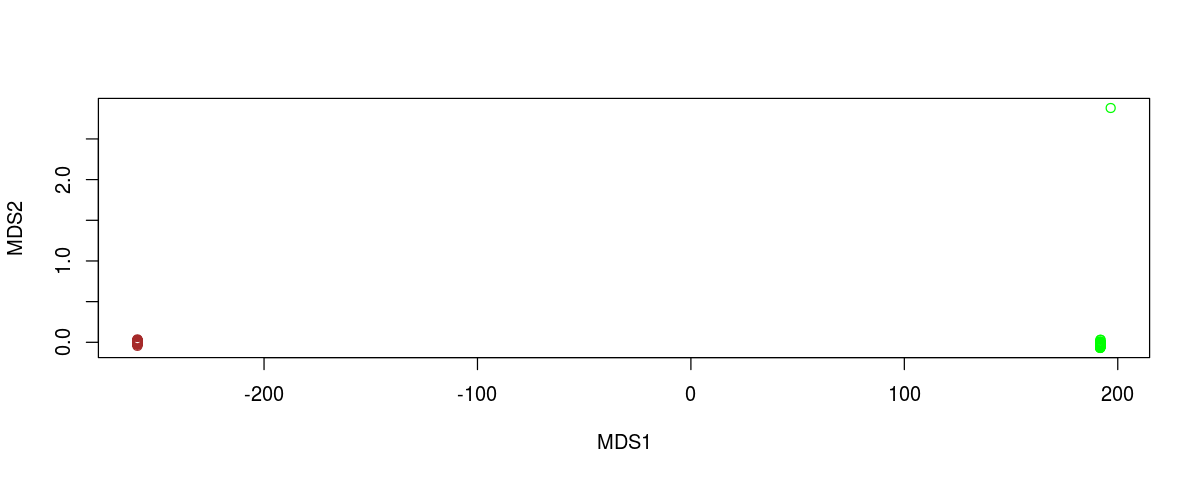

In [84]:
plot(WvsL$points, col=color)

Weird, we have complete separation, unlike last time... Cutoffs too stringent? Look at this without the outlier...

In [ ]:
identify(WvsL$points) ##181

Wisconsin double standardization
Run 0 stress 8.954737e-05 
Run 1 stress 9.190804e-05 
... Procrustes: rmse 3.928785e-05  max resid 0.0004408048 
... Similar to previous best
Run 2 stress 9.379337e-05 
... Procrustes: rmse 3.602598e-05  max resid 0.0003702779 
... Similar to previous best
Run 3 stress 9.147567e-05 
... Procrustes: rmse 3.263903e-05  max resid 0.0003767296 
... Similar to previous best
Run 4 stress 8.765039e-05 
... New best solution
... Procrustes: rmse 2.178718e-05  max resid 0.0001101781 
... Similar to previous best
Run 5 stress 8.773564e-05 
... Procrustes: rmse 3.303455e-05  max resid 0.000338349 
... Similar to previous best
Run 6 stress 9.959286e-05 
... Procrustes: rmse 3.305523e-05  max resid 0.0003628473 
... Similar to previous best
Run 7 stress 9.758524e-05 
... Procrustes: rmse 3.523646e-05  max resid 0.0003298133 
... Similar to previous best
Run 8 stress 9.685904e-05 
... Procrustes: rmse 3.613546e-05  max resid 0.0004043215 
... Similar to previous best

Warning message in metaMDS(nmsmat_noOut):
“stress is (nearly) zero: you may have insufficient data”

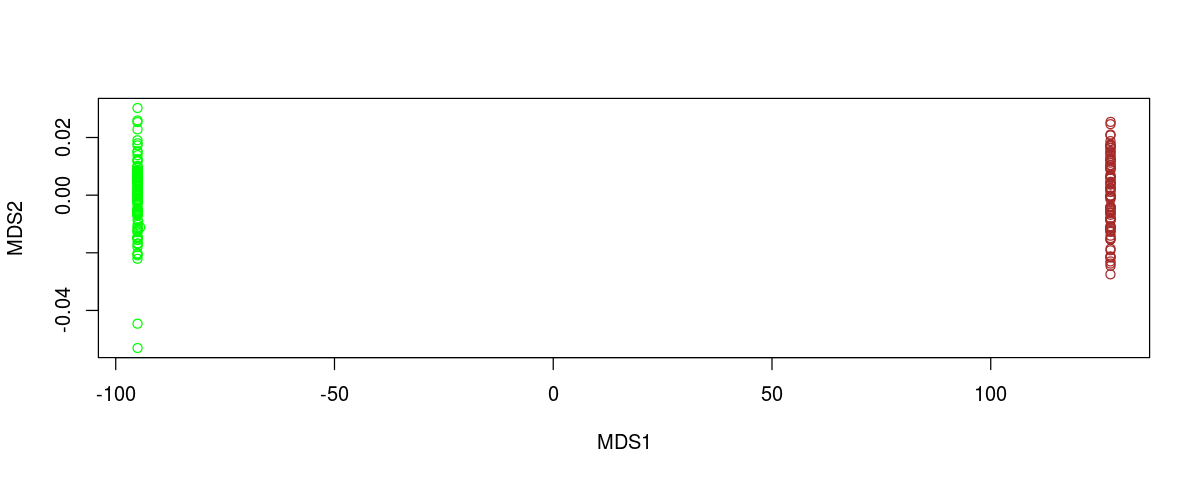

In [86]:
nmsmat_noOut <- nmsmat[-181,]
WvsL_noOut <- metaMDS(nmsmat_noOut)
color <- NULL
color[1:91] <- 'brown'
color[92:214] <- 'green'
plot(WvsL_noOut$points, col=color)

Hmm. Total separation... Our last analysis showed some overlap... the only difference I can think of is that I cleaned the negatives separately. Apparently it made a difference. 

Do we see any sort of difference if we transform our data to presence/absence?

In [89]:
nmsmat.PA <- nmsmat_noOut
nmsmat.PA[nmsmat.PA > 0] <- 1
WvsL.PA <- metaMDS(nmsmat.PA)

Run 0 stress 9.075196e-05 
Run 1 stress 9.119895e-05 
... Procrustes: rmse 2.578939e-05  max resid 9.191718e-05 
... Similar to previous best
Run 2 stress 8.633431e-05 
... New best solution
... Procrustes: rmse 3.826129e-05  max resid 0.0003420187 
... Similar to previous best
Run 3 stress 9.589004e-05 
... Procrustes: rmse 3.221965e-05  max resid 0.0002469573 
... Similar to previous best
Run 4 stress 9.096515e-05 
... Procrustes: rmse 3.41114e-05  max resid 0.0003903983 
... Similar to previous best
Run 5 stress 8.86225e-05 
... Procrustes: rmse 2.104221e-05  max resid 0.0001564683 
... Similar to previous best
Run 6 stress 9.54635e-05 
... Procrustes: rmse 4.057168e-05  max resid 0.0004528917 
... Similar to previous best
Run 7 stress 9.080032e-05 
... Procrustes: rmse 4.615923e-05  max resid 0.0005363398 
... Similar to previous best
Run 8 stress 8.31665e-05 
... New best solution
... Procrustes: rmse 3.373823e-05  max resid 0.0003856375 
... Similar to previous best
Run 9 stress 

Warning message in metaMDS(nmsmat.PA):
“stress is (nearly) zero: you may have insufficient data”

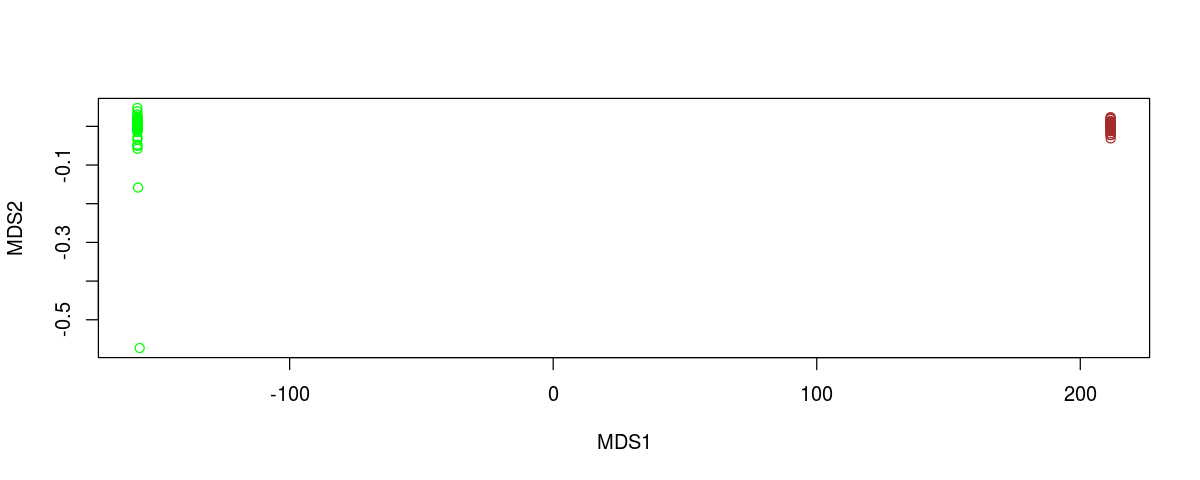

In [90]:
plot(WvsL.PA$points, col=color)

Pretty similar...

<a id='WvLshared'><h3>Wood vs. Leaf endophyte comparison, look for shared species</h3></a>


In [93]:
wood <- subset_samples(deseq95, Library=="W")
leaf <- subset_samples(deseq95, Library=="L")

In [94]:
## reduce these OTU tables to non-zero rows:
woodOTU <- otu_table(wood) ## otus are rows
woodspp <- rownames(woodOTU[rowSums(woodOTU)>0,])

In [95]:
## do the same for the leaves:
leafOTU <- otu_table(leaf)
leafspp <- rownames(leafOTU[rowSums(leafOTU)>0,])

In [99]:
leafspp

[1] "OTU19:100leaf"    "OTU108:100leaf"   "OTU1:100leaf"    
   [4] "OTU202:100leaf"   "OTU426:100leaf"   "OTU10:100leaf"   
   [7] "OTU17:100leaf"    "OTU429:100leaf"   "OTU15:100leaf"   
  [10] "OTU27:100leaf"    "OTU355:100leaf"   "OTU22:101leaf"   
  [13] "OTU91:100leaf"    "OTU570:100leaf"   "OTU406:100leaf"  
  [16] "OTU181:100leaf"   "OTU520:100leaf"   "OTU73:100leaf"   
  [19] "OTU159:100leaf"   "OTU794:16leaf"    "OTU297:100leaf"  
  [22] "OTU252:117leaf"   "OTU1199:41leaf"   "OTU951:14leaf"   
  [25] "OTU412:102leaf"   "OTU78:100leaf"    "OTU226:100leaf"  
  [28] "OTU282:100leaf"   "OTU468:107leaf"   "OTU209:101leaf"  
  [31] "OTU368:100leaf"   "OTU381:66leaf"    "OTU883:107leaf"  
  [34] "OTU239:100leaf"   "OTU1006:100leaf"  "OTU1938:130leaf" 
  [37] "OTU1495:100leaf"  "OTU93:100leaf"    "OTU1071:100leaf" 
  [40] "OTU263:100leaf"   "OTU371:110leaf"   "OTU2975:100leaf" 
  [43] "OTU319:100leaf"   "OTU303:111leaf"   "OTU1159:103leaf" 
  [46] "OTU613:100leaf"   "OTU1134:100leaf"  "OTU1182:100leaf" 
  [49] "OTU360:100leaf"   "OTU70:100leaf"    "OTU1690:100leaf" 
  [52] "OTU247:17leaf"    "OTU16:100leaf"    "OTU45:100leaf"   
  [55] "OTU1731:100leaf"  "OTU584:100leaf"   "OTU53:107leaf"   
  [58] "OTU591:100leaf"   "OTU1657:104leaf"  "OTU1224:101leaf" 
  [61] "OTU1151:51leaf"   "OTU668:100leaf"   "OTU280:100leaf"  
  [64] "OTU736:100leaf"   "OTU514:125leaf"   "OTU1543:100leaf" 
  [67] "OTU1169:100leaf"  "OTU61:100leaf"    "OTU890:100leaf"  
  [70] "OTU97:102leaf"    "OTU540:14leaf"    "OTU1140:100leaf" 
  [73] "OTU3:102leaf"     "OTU1816:105leaf"  "OTU94:114leaf"   
  [76] "OTU2267:100leaf"  "OTU635:100leaf"   "OTU2082:16leaf"  
  [79] "OTU199:101leaf"   "OTU74:101leaf"    "OTU262:101leaf"  
  [82] "OTU110:101leaf"   "OTU797:101leaf"   "OTU667:101leaf"  
  [85] "OTU284:101leaf"   "OTU1586:101leaf"  "OTU446:101leaf"  
  [88] "OTU42:101leaf"    "OTU729:116leaf"   "OTU1830:101leaf" 
  [91] "OTU1927:101leaf"  "OTU1047:101leaf"  "OTU4:101leaf"    
  [94] "OTU2005:101leaf"  "OTU372:117leaf"   "OTU340:103leaf"  
  [97] "OTU2175:101leaf"  "OTU194:119leaf"   "OTU462:101leaf"  
 [100] "OTU457:101leaf"   "OTU124:101leaf"   "OTU405:101leaf"  
 [103] "OTU545:47leaf"    "OTU436:102leaf"   "OTU43:101leaf"   
 [106] "OTU2259:101leaf"  "OTU346:101leaf"   "OTU846:101leaf"  
 [109] "OTU115:101leaf"   "OTU2066:101leaf"  "OTU666:120leaf"  
 [112] "OTU8842:131leaf"  "OTU511:101leaf"   "OTU705:114leaf"  
 [115] "OTU824:120leaf"   "OTU343:103leaf"   "OTU1144:101leaf" 
 [118] "OTU546:101leaf"   "OTU116:117leaf"   "OTU261:102leaf"  
 [121] "OTU549:132leaf"   "OTU218:102leaf"   "OTU677:15leaf"   
 [124] "OTU663:110leaf"   "OTU1841:116leaf"  "OTU946:101leaf"  
 [127] "OTU583:13leaf"    "OTU831:101leaf"   "OTU3181:107leaf" 
 [130] "OTU3042:41leaf"   "OTU1142:101leaf"  "OTU454:101leaf"  
 [133] "OTU1213:101leaf"  "OTU378:101leaf"   "OTU1813:117leaf" 
 [136] "OTU1436:101leaf"  "OTU940:103leaf"   "OTU788:104leaf"  
 [139] "OTU8836:14leaf"   "OTU2103:15leaf"   "OTU744:104leaf"  
 [142] "OTU681:101leaf"   "OTU5825:114leaf"  "OTU717:128leaf"  
 [145] "OTU489:125leaf"   "OTU182:30leaf"    "OTU448:1leaf"    
 [148] "OTU1576:14leaf"   "OTU2497:131leaf"  "OTU5:102leaf"    
 [151] "OTU109:102leaf"   "OTU54:102leaf"    "OTU100:102leaf"  
 [154] "OTU173:13leaf"    "OTU422:62leaf"    "OTU1088:102leaf" 
 [157] "OTU812:102leaf"   "OTU89:102leaf"    "OTU1025:3leaf"   
 [160] "OTU660:102leaf"   "OTU3689:102leaf"  "OTU644:102leaf"  
 [163] "OTU244:115leaf"   "OTU79:102leaf"    "OTU2372:102leaf" 
 [166] "OTU1318:1leaf"    "OTU208:103leaf"   "OTU1359:130leaf" 
 [169] "OTU1554:102leaf"  "OTU2:102leaf"     "OTU1963:102leaf" 
 [172] "OTU1064:75leaf"   "OTU311:102leaf"   "OTU470:103leaf"  
 [175] "OTU852:102leaf"   "OTU65:102leaf"    "OTU956:103leaf"  
 [178] "OTU440:102leaf"   "OTU309:117leaf"   "OTU330:102leaf"  
 [181] "OTU1734:102leaf"  "OTU572:102leaf"   "OTU1654:2leaf"   
 [184] "OTU509:102leaf"   "OTU86:102leaf"    "OTU268:102leaf"  
 [187] "OTU48:102leaf"    "OTU538:1

In [101]:
any(woodspp %in% leafspp)

[1] FALSE

In [102]:
any(leafspp %in% woodspp)

[1] FALSE

Huh, no shared species... might be in for a ride now... let's see what other differences present.

<a id='HostNMS'><h3>Host NMS/PermANOVA</h3></a>

Let's look for grouping of samples by host. It is difficult here to disentangle spatial patterns of the host and microbe here, if we find "host preference" this may be due to fungal species simply preferring the same habitat as the host, and not host-microbe interactions, etc. But a first look is needed. 

<a id='woodHostNMS'><h4>Wood library, Host effects</h4></a>


In [104]:
woodbiom  <- subset_samples(deseq95, Library=='W')
woodOTU <- otu_table(woodbiom)
wood <- t(woodOTU@.Data) ## transpose, default phyloseq uses otus as rows
wood_data <- sample_data(woodbiom)
WoodMDS <- metaMDS(wood)

Wisconsin double standardization
Run 0 stress 0.2762519 
Run 1 stress 0.2861963 
Run 2 stress 0.2798003 
Run 3 stress 0.2768649 
Run 4 stress 0.2800364 
Run 5 stress 0.2760376 
... New best solution
... Procrustes: rmse 0.05330076  max resid 0.3131359 
Run 6 stress 0.2745264 
... New best solution
... Procrustes: rmse 0.09014175  max resid 0.4031058 
Run 7 stress 0.2769832 
Run 8 stress 0.2737327 
... New best solution
... Procrustes: rmse 0.04985925  max resid 0.2799055 
Run 9 stress 0.2792227 
Run 10 stress 0.2783602 
Run 11 stress 0.2774815 
Run 12 stress 0.2722429 
... New best solution
... Procrustes: rmse 0.04791228  max resid 0.2363086 
Run 13 stress 0.2743483 
Run 14 stress 0.279028 
Run 15 stress 0.2753582 
Run 16 stress 0.2803394 
Run 17 stress 0.2746752 
Run 18 stress 0.2766783 
Run 19 stress 0.2758248 
Run 20 stress 0.279634 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


In [108]:
samps <- table(wood_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(wood_data$Host_genus_species, FUN= function(x){which(spp == x)})
n <- length(spp)
palette <- distinctColorPalette(n)

Before we plot, just checking, what do our samples sizes look like for each tree host?

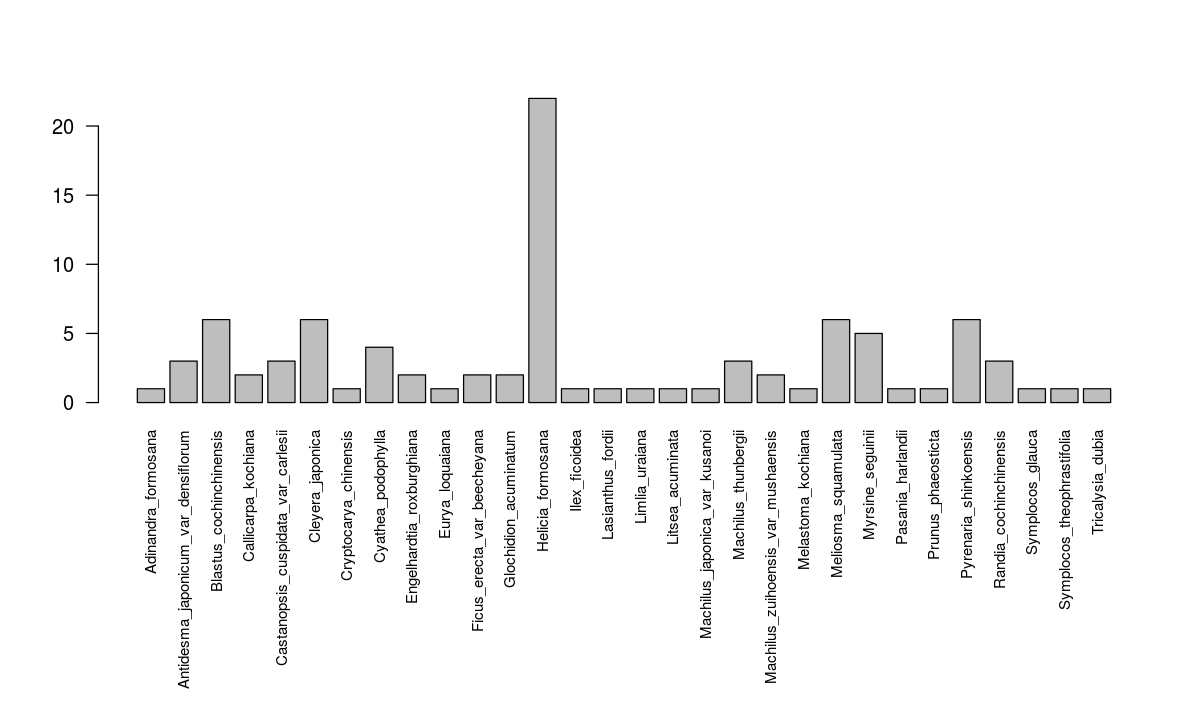

In [109]:
options(repr.plot.width = 10,repr.plot.height = 6)
par(oma=c(8,0,0,0))
barplot(samps, las=2, cex.names=.75)

Definitely some pretty uneven sample sizes. 

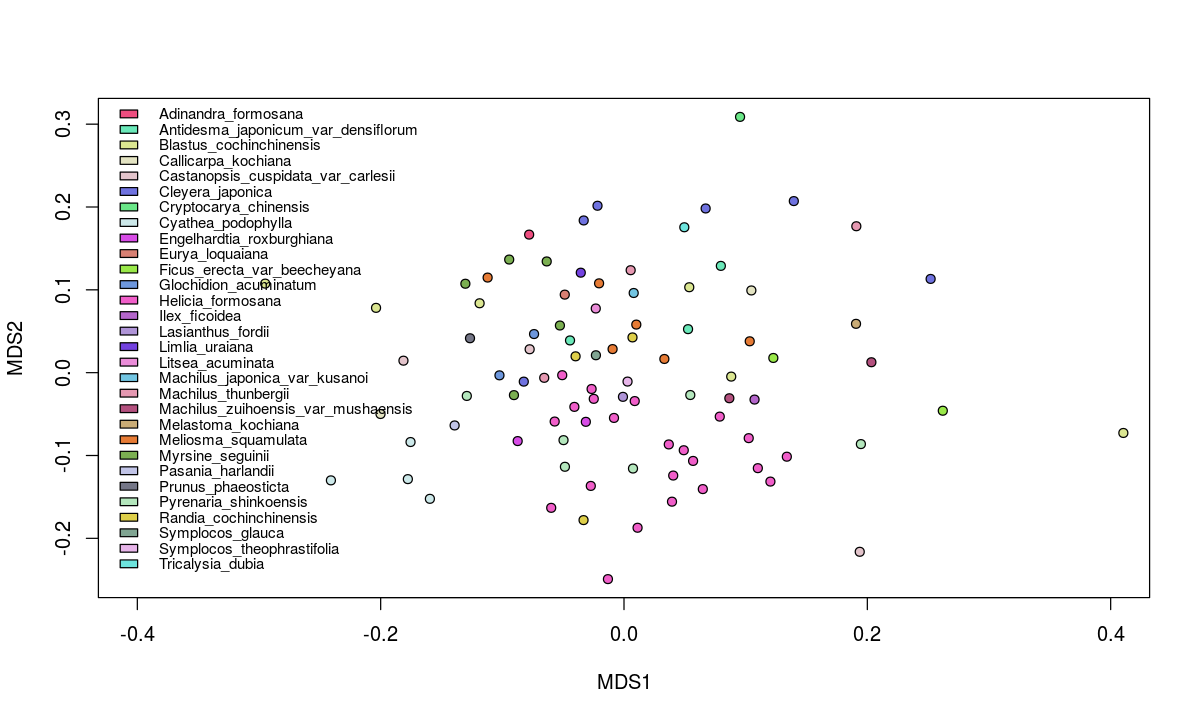

In [110]:
plot(WoodMDS$points,
    bg=palette[hostspp],
    col='black',
    pch=21,
    xlim=c(-0.4,0.4)
    )
legend('topleft',
        legend=spp,
        fill=palette,
        cex=.75,
        bty='n')

Suggestive, looks like some host communities are grouping together. We have a lot of low-sample hosts, we can remove host trees with less than 3 samples from the graphic to clear things up a bit. 

In [111]:
hisamps <- samps[samps > 2] ## only hosts with >2 samples
hihosts <- wood_data$Host_genus_species %in% names(hisamps)
## make new groups/color palette
hispp <- names(hisamps)
hihostspp <- sapply(wood_data$Host_genus_species[hihosts], FUN= function(x){which(hispp == x)})
n <- length(hispp)
palette <- distinctColorPalette(n)

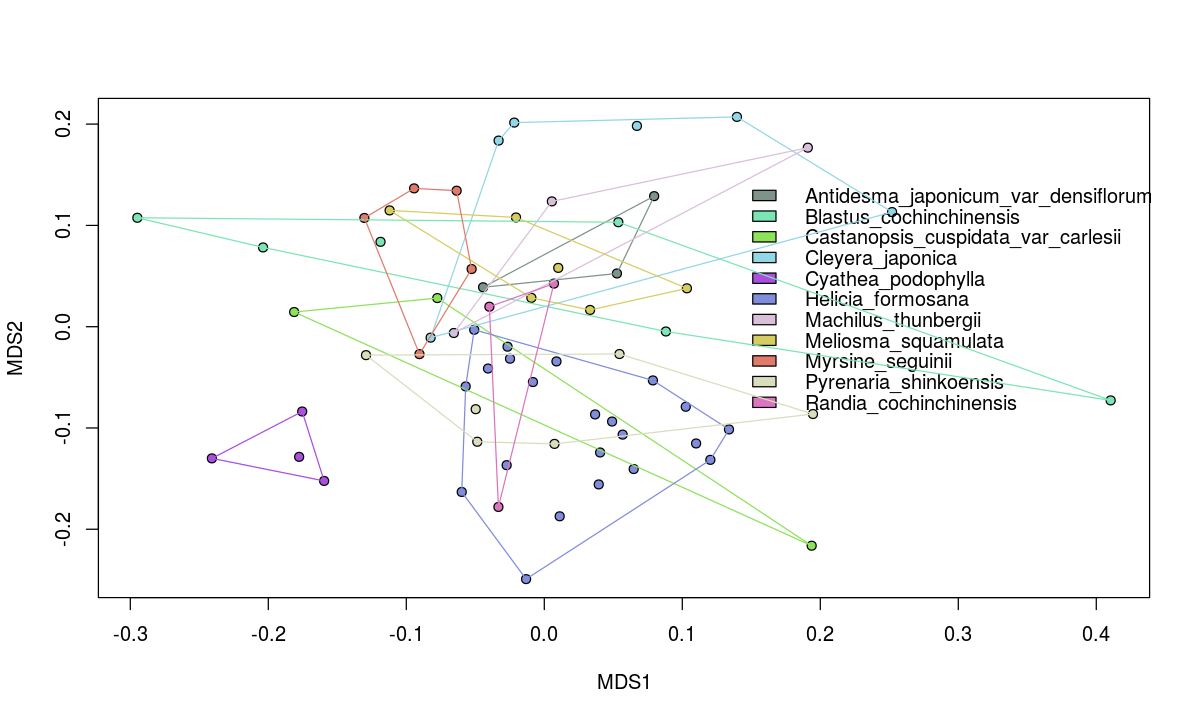

In [113]:
#png('woodhostNMS.png')
plot(WoodMDS$points[hihosts,],
    col="black",
    pch = 21,
    bg = palette[hihostspp],
    #xlim = c(-0.15,.35),
)
legend( x=.13,
    y=0.15,
    legend=hispp,
    fill=palette,
    bty='n')

## hulls have to be drawn one by one if we use ordihull():
for(i in 1:length(hispp)){
ordihull(WoodMDS, groups=wood_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}
#dev.off()

In [114]:
testwoodhost <- adonis(wood ~ wood_data$Host_genus_species, permutations=10000)

In [115]:
testwoodhost


Call:
adonis(formula = wood ~ wood_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                             Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
wood_data$Host_genus_species 29    14.849 0.51205  1.4945 0.41538 9.999e-05 ***
Residuals                    61    20.900 0.34262         0.58462              
Total                        90    35.749                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Again, hard to trust these numbers given that we are ignoring spatial aspects of this, and there are dispersion differences. The NMS figures show a centroid location difference among several groups, though.

Check the dispersion.

In [117]:
dis <- vegdist(wood)
disp <- betadisper(dis, hostspp)
disp
anova(disp) ## still significantly different


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = hostspp)

No. of Positive Eigenvalues: 90
No. of Negative Eigenvalues: 0

Average distance to median:
     1      2      3      4      5      6      7      8      9     10     11 
0.0000 0.4780 0.6045 0.3732 0.5271 0.5659 0.0000 0.5197 0.3966 0.0000 0.3808 
    12     13     14     15     16     17     18     19     20     21     22 
0.3524 0.5647 0.0000 0.0000 0.0000 0.0000 0.0000 0.5006 0.4173 0.0000 0.5045 
    23     24     25     26     27     28     29     30 
0.4595 0.0000 0.0000 0.5112 0.4714 0.0000 0.0000 0.0000 

Eigenvalues for PCoA axes:
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
2.1934 1.9167 1.6608 1.4984 1.1265 0.9894 0.9303 0.8360 

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,29,3.4684323,0.119601113,42.94714,1.081307e-30
Residuals,61,0.1698755,0.002784845,NA,NA


In [118]:
permutest(disp, pairwise = TRUE)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df Sum Sq  Mean Sq      F N.Perm Pr(>F)    
Groups    29 3.4684 0.119601 42.947    999  0.001 ***
Residuals 61 0.1699 0.002785                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
   1          2          3          4          5          6 7          8
1                                                                       
2               1.1000e-02 3.4000e-02 5.3400e-01 1.8000e-02   2.6100e-01
3    8.1856e-03            7.0000e-03 1.6000e-01 2.0700e-01   2.1000e-02
4    2.6798e-02 1.1792e-03            1.1400e-01 1.2000e-02   1.5000e-02
5    4.9550e-01 1.8071e-01 1.5267e-01            4.9800e-01   9.2200e-01
6    1.6664e-02 1.9517e-01 8.0972e-04 4.4475e-01              1.3700e-01
7                                        

Do a type of tukeys to show why there are significant differences in dispersion among our host/microbe groupings.

In [119]:
disp.HSD <- TukeyHSD(disp)

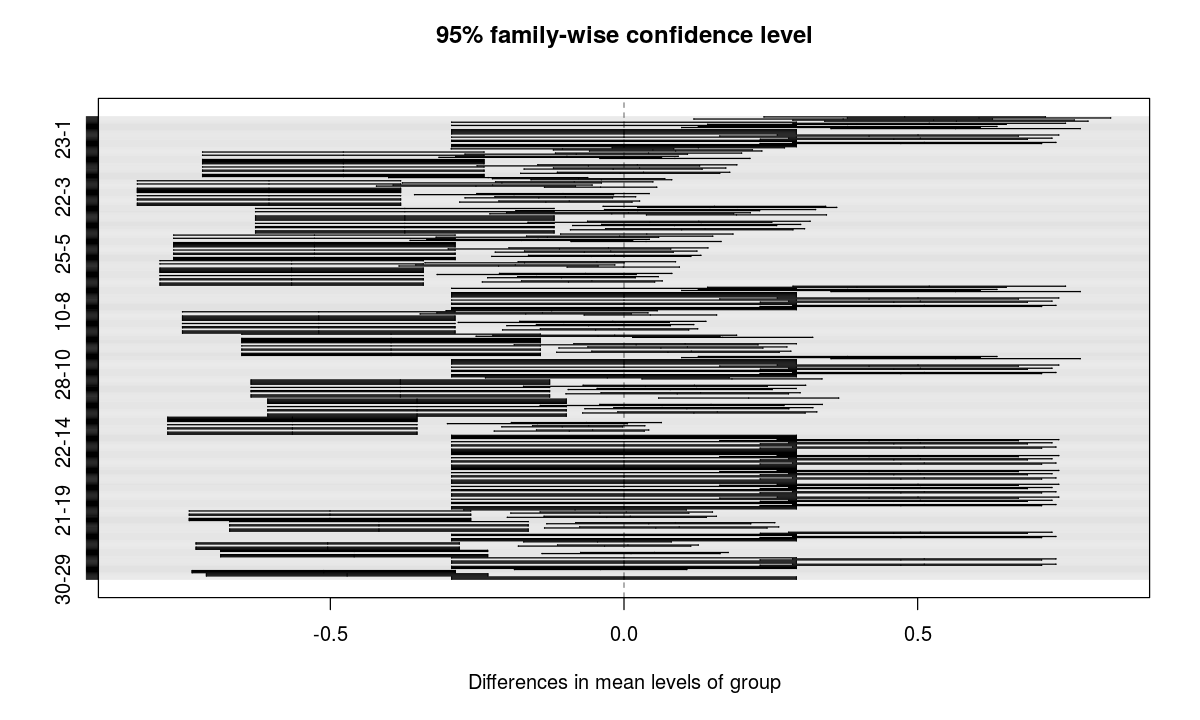

In [120]:
plot(disp.HSD)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '30'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '29'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '28'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimpl

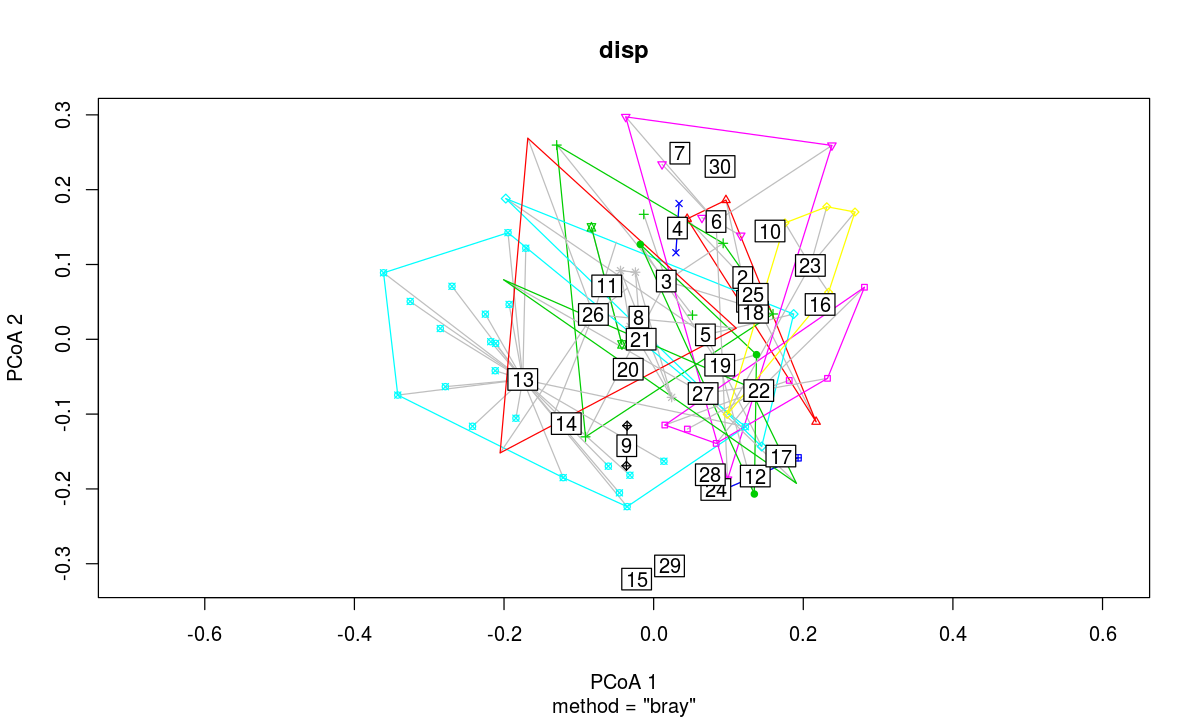

In [121]:
plot(disp)

These are distances along principal coordinates of the BC disimilarity matrix of the community matrix. I'm not sure how to interprest these units.  [Jari Oksanen's documentation](http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/betadisper.html) explains some, this seems to be a way of dealing with the non-euclidean disimilarity metrics like BC. but I really have no idea what these graphs mean in biological terms, except that I assume that the first is a classic tukeys comparison among all the host-groups. I.e., if comparisons that wander far away from the zero are very different in their dispersions and having comparisons all over the chart like this reinforces that we have lots of different sized dispersions. 

I don't really think there is much here that we can't see in the NMS - dispersions vary among the samples when grouped by host. 

<a id='leafHostNMS'><h4>Leaf library, Host effects</h4></a>


In [130]:
load('deseq95.rda')
leafbiom  <- subset_samples(deseq95, Library=='L')
leafOTU <- otu_table(leafbiom)
leaf <- t(leafOTU@.Data)
leaf_data <- sample_data(leafbiom)
leafMDS <- metaMDS(leaf)

Wisconsin double standardization
Run 0 stress 0.1260886 
Run 1 stress 0.126286 
... Procrustes: rmse 0.007593137  max resid 0.02835048 
Run 2 stress 0.1261514 
... Procrustes: rmse 0.005385356  max resid 0.02302638 
Run 3 stress 0.1262231 
... Procrustes: rmse 0.006093234  max resid 0.02625702 
Run 4 stress 0.1261953 
... Procrustes: rmse 0.00556488  max resid 0.02256784 
Run 5 stress 0.1261427 
... Procrustes: rmse 0.008918071  max resid 0.0310009 
Run 6 stress 0.1261769 
... Procrustes: rmse 0.009147585  max resid 0.03085108 
Run 7 stress 0.1263541 
... Procrustes: rmse 0.009491294  max resid 0.03489594 
Run 8 stress 0.1262606 
... Procrustes: rmse 0.007201247  max resid 0.01976357 
Run 9 stress 0.1260835 
... New best solution
... Procrustes: rmse 0.006365073  max resid 0.02962531 
Run 10 stress 0.1263009 
... Procrustes: rmse 0.006884862  max resid 0.03019338 
Run 11 stress 0.126175 
... Procrustes: rmse 0.004563682  max resid 0.03072516 
Run 12 stress 0.1262071 
... Procrustes: rm

In [132]:
#save(leafMDS, file='leafMDS.rda')

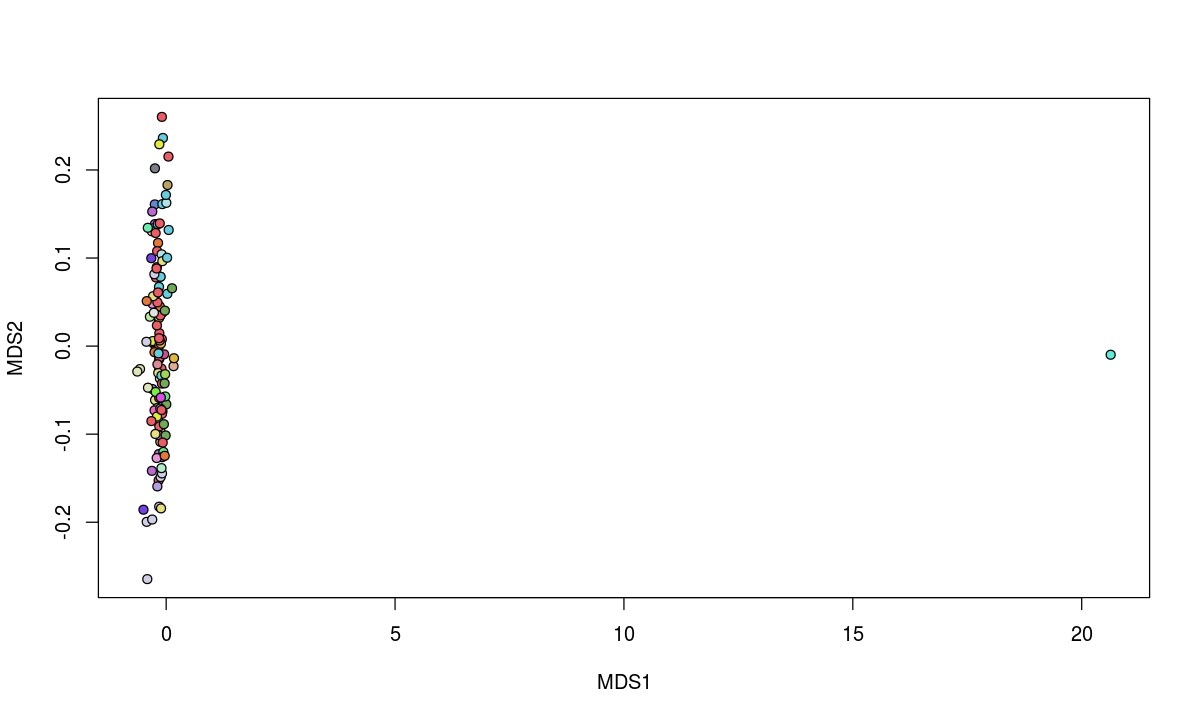

In [131]:
## host groups/colors
samps <- table(leaf_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(leaf_data$Host_genus_species, FUN= function(x){which(spp == x)})
#spp == sort(unique(leaf_data$Host_genus_species)) ## yup, table function does this
n <- length(spp)
palette <- distinctColorPalette(n)

plot(leafMDS$points,
        col="black",
        pch = 21,
        bg = palette[hostspp]
)

Deal with outlier.

In [135]:
aa <- identify(leafMDS$points)
leafMDS$points[aa,,drop=FALSE]

,MDS1,MDS2
67leaf,20.63293,-0.009804052


In [137]:
load('deseq95.rda')
leafbiom  <- subset_samples(deseq95, Library=='L')
leafOTU <- otu_table(leafbiom)
leaf <- t(leafOTU@.Data)
leaf <- leaf[-90,]

In [138]:
leafMDS <- metaMDS(leaf)

Wisconsin double standardization
Run 0 stress 0.2272767 
Run 1 stress 0.2203699 
... New best solution
... Procrustes: rmse 0.07339197  max resid 0.3181283 
Run 2 stress 0.2230265 
Run 3 stress 0.2201943 
... New best solution
... Procrustes: rmse 0.01102991  max resid 0.09303904 
Run 4 stress 0.2210349 
Run 5 stress 0.2230518 
Run 6 stress 0.2259905 
Run 7 stress 0.2235106 
Run 8 stress 0.2239187 
Run 9 stress 0.2241218 
Run 10 stress 0.2238084 
Run 11 stress 0.2233761 
Run 12 stress 0.2230083 
Run 13 stress 0.2227444 
Run 14 stress 0.22405 
Run 15 stress 0.2233544 
Run 16 stress 0.2213994 
Run 17 stress 0.2237483 
Run 18 stress 0.2221847 
Run 19 stress 0.2223765 
Run 20 stress 0.2244438 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


In [ ]:
leafMDS <- metaMDS(leaf)